In [1]:
library(dplyr)
library(tabplot)
library(discretization)
library(pryr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: bit
Attaching package bit
package:bit (c) 2008-2012 Jens Oehlschlaegel (GPL-2)
creators: bit bitwhich
coercion: as.logical as.integer as.bit as.bitwhich which
operator: ! & | xor != ==
querying: print length any all min max range sum summary
bit access: length<- [ [<- [[ [[<-
for more help type ?bit

Attaching package: ‘bit’

The following object is masked from ‘package:base’:

    xor

Loading required package: ff
Attaching package ff
- getOption("fftempdir")=="/var/folders/9d/ql46h1757fsff_cwqg8kymm40000gn/T//RtmpFeTusC"

- getOption("ffextension")=="ff"

- getOption("ffdrop")==TRUE

- getOption("fffinonexit")==TRUE

- getOption("ffpagesize")==65536

- getOption("ffcaching")=="mmnoflush"  -- consider "ffeachflush" if your system stalls on large writes

- getOption

In [2]:
L <- function(..., sep = "", collapse = NULL) {
    paste(..., sep = sep, collapse = collapse)
}

L <- function(..., f) {
    if (missing(f)) 
        f <- paste(rep("%s", length(c(...))), collapse = "")
    sprintf(fmt = f, ...)
}

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")

In [4]:
raw <- read.csv("../data/middle/sp4.csv", stringsAsFactors=FALSE)
df <- raw

In [5]:
summary(select(raw, AverageVelocity, MaxSpeed, MinSpeed))

 AverageVelocity       MaxSpeed         MinSpeed     
 Min.   :  0.0357   Min.   :  2.89   Min.   : 0.000  
 1st Qu.: 12.4269   1st Qu.: 37.69   1st Qu.: 0.000  
 Median : 22.4262   Median : 44.69   Median : 0.000  
 Mean   : 26.1326   Mean   : 47.75   Mean   : 7.044  
 3rd Qu.: 32.8881   3rd Qu.: 57.76   3rd Qu.: 0.000  
 Max.   :102.0546   Max.   :106.43   Max.   :98.820  

In [6]:
names(df)

[1] "Time"              "Longitude"         "Latitude"         
 [4] "Speed"             "Brake"             "Accel"            
 [7] "Engine"            "AheadDistance"     "Curve150"         
[10] "Curve100"          "Curve"             "SteeringAngle"    
[13] "BranchFlag"        "DistTollgate"      "RoadType"         
[16] "GreenLamp"         "RedLamp"           "RightLamp"        
[19] "UpLamp"            "LeftLamp"          "StopSign"         
[22] "Limit30Sign"       "Limit50Sign"       "BrakeCar"         
[25] "LeftCar"           "ManBicycleCount"   "ManBicycle"       
[28] "DistManBicycle"    "Pitch"             "DistSignal"       
[31] "PathType"          "LaneCount"         "AccelerationSpeed"
[34] "Jerk"              "AverageVelocity"   "MaxSpeed"         
[37] "MinSpeed"          "CurveAverage"      "TimeHeadway"      
[40] "TimeToCollision"   "RiskFactor"        "flag"

In [7]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')

In [8]:
availColumns <- c('Speed', 'AheadDistance', 'AverageVelocity', 'TimeHeadway', 'RoadType', 'TimeToCollision', 'RiskFactor',
                  'CurveAverage', 'Curve', 'Engine', 'Pitch', 'SteeringAngle', 'DistSignal', 'AccelerationSpeed', 'LaneCount', 'Jerk', 'PathType')

In [9]:
automateColumns <- c("Speed", "AheadDistance", "CurveAverage", "DistSignal", "Pitch", "TimeHeadway", "LaneCount", "AccelerationSpeed", "Jerk", "Curve", "Engine")
manualColumns <- c("AverageVelocity", "RiskFactor", "SteeringAngle", "Pitch")

In [10]:
df$flag[df$flag == "RedA"] <- "Red"
df$flag[df$flag == "RedB"] <- "Red"
df$flag[df$flag == "BlueA"] <- "Blue"
df$flag[df$flag == "BlueB"] <- "Blue"
df$flag <- as.factor(df$flag)

In [11]:
highOuter <- function(firstQu, thirdQu) thirdQu + 1.5*(thirdQu - firstQu)
lowOuter <- function(firstQu, thirdQu) firstQu - 1.5*(thirdQu - firstQu)

In [12]:
thresholdOrIdentity <- function(operator, thresholdFunc, firstQu, thirdQu, val) {
    threshold <- thresholdFunc(firstQu, thirdQu)
    if (do.call(operator, list(val, threshold)))
        return(val)
    return(threshold)
}
    
highOrIdentity <- pryr::partial(thresholdOrIdentity, "<", highOuter)
lowOrIdentity <- pryr::partial(thresholdOrIdentity, ">", lowOuter)

In [13]:
rmOutlier <- function(thresholdFunc, df, col) {
    quant <- quantile(df[[col]])
    firstQu <- quant[2]
    thirdQu <- quant[4]
    idx <- match(col, names(df))
    apply(select(df, idx), 1, pryr::partial(thresholdFunc, firstQu, thirdQu))
}

In [14]:
rmHighOutlier <- partial(rmOutlier, highOrIdentity)
rmLowOutlier <- partial(rmOutlier, lowOrIdentity)

In [15]:
# df[automateColumns] <- sapply(automateColumns, function(x) rmHighOutlier(df, x))
# df[automateColumns] <- sapply(automateColumns, function(x) rmLowOutlier(df, x))

In [16]:
showHists <- function(dfx, col) {
    plot <- qplot(df[[col]], geom="histogram", main=col, xlab=col)
    # ggsave(plot, file=cat(col, ".png", sep=""))
    print(plot)
}
# sapply(availColumns, function(x) showHists(df, x))

# Threshold

In [17]:
thresholdOrIdentity <- function(operator, threshold, val) {
    if (do.call(operator, list(val, threshold)))
        return(val)
    return(threshold)
}

In [18]:
df <- raw

# DistSignal

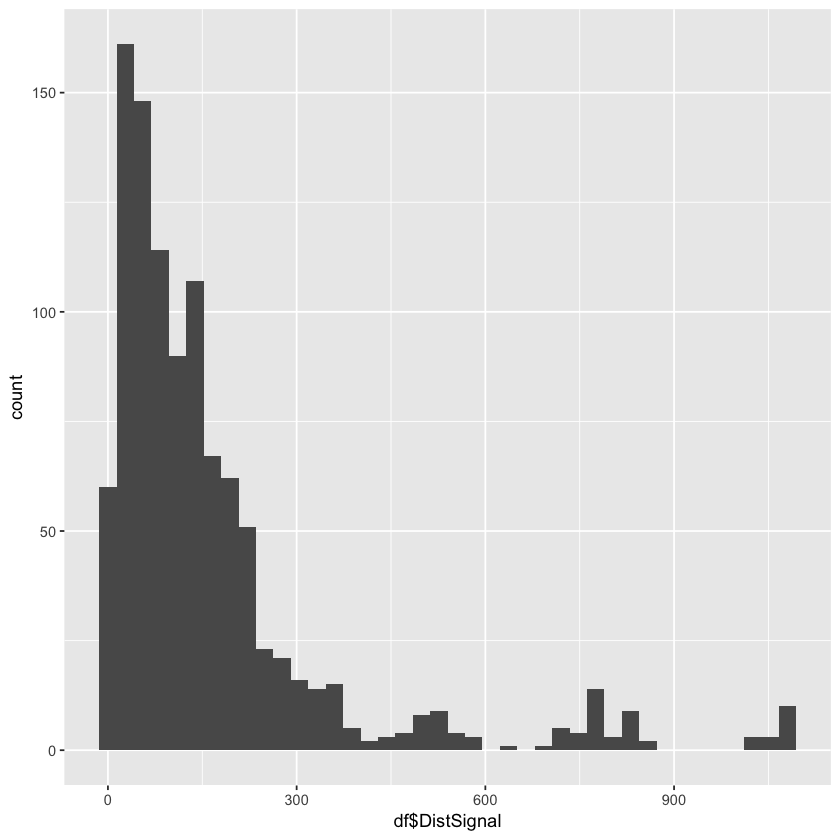

In [19]:
p <- qplot(df$DistSignal, geom="histogram", bins=40)
print(p)

In [20]:
df$DistSignal <- sapply(df$DistSignal, FUN=pryr::partial(thresholdOrIdentity, "<", 300))
summary(df$DistSignal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.22   49.11  109.00  128.90  192.80  300.00 

# Engine

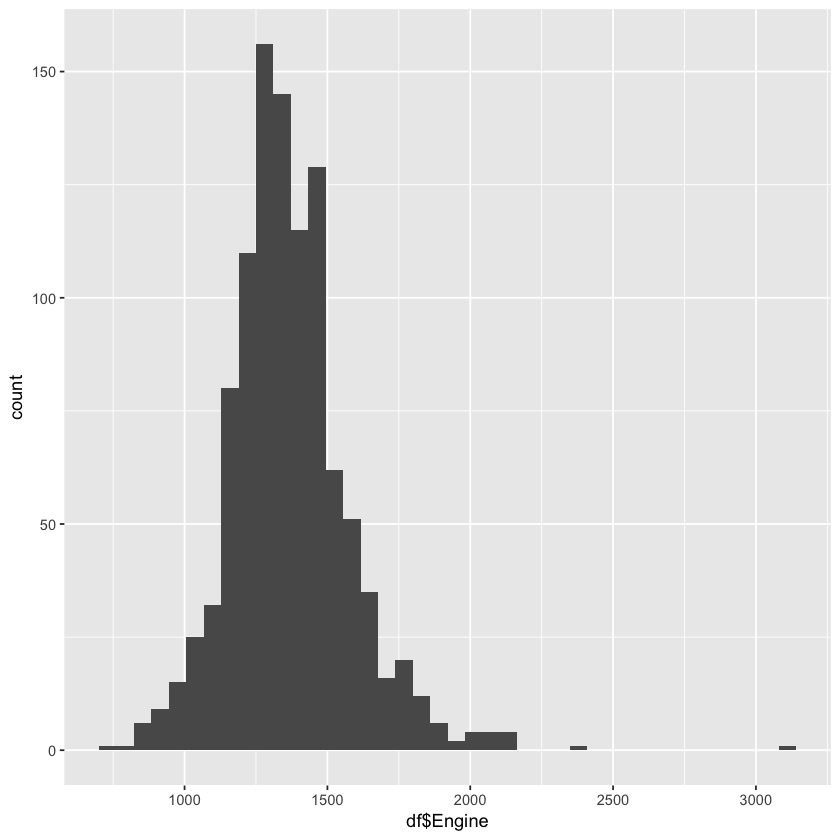

In [21]:
p <- qplot(df$Engine, geom="histogram", bins=40)
print(p)

In [22]:
df$Engine <- sapply(df$Engine, FUN=pryr::partial(thresholdOrIdentity, "<", 2000))
summary(df$Engine)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  731.2  1241.0  1347.0  1365.0  1472.0  2000.0 

# PathType ( VC_NaviCls )

Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


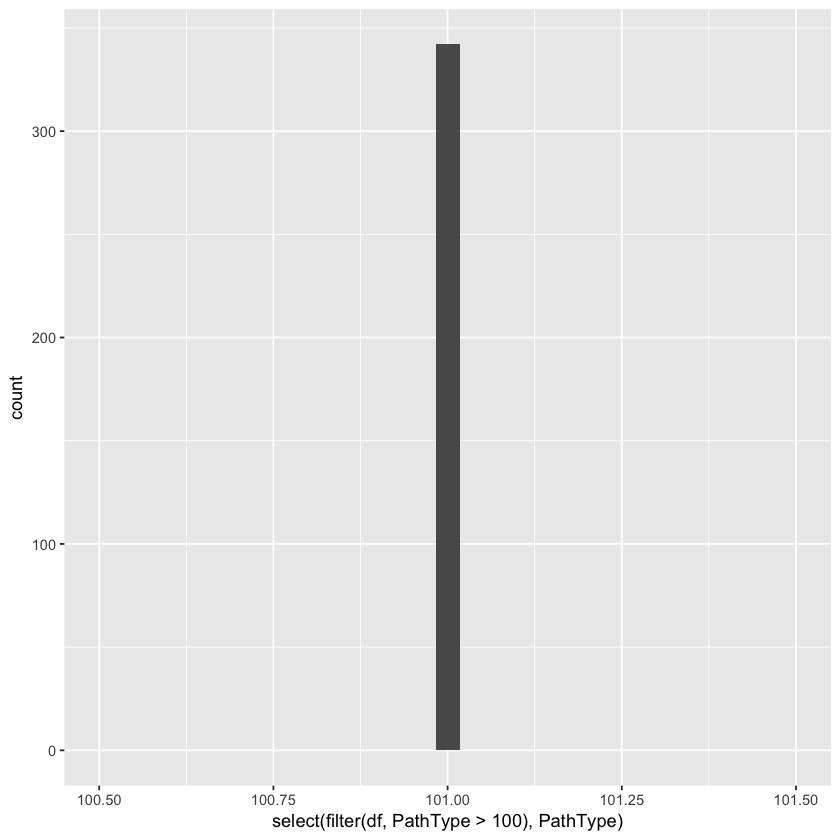

In [23]:
p <- qplot(select(filter(df, PathType > 100), PathType), geom="histogram")
print(p)

# Pitch

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-2.4870000 -0.0768700  0.0002488 -0.0039820  0.0403000  2.4840000 

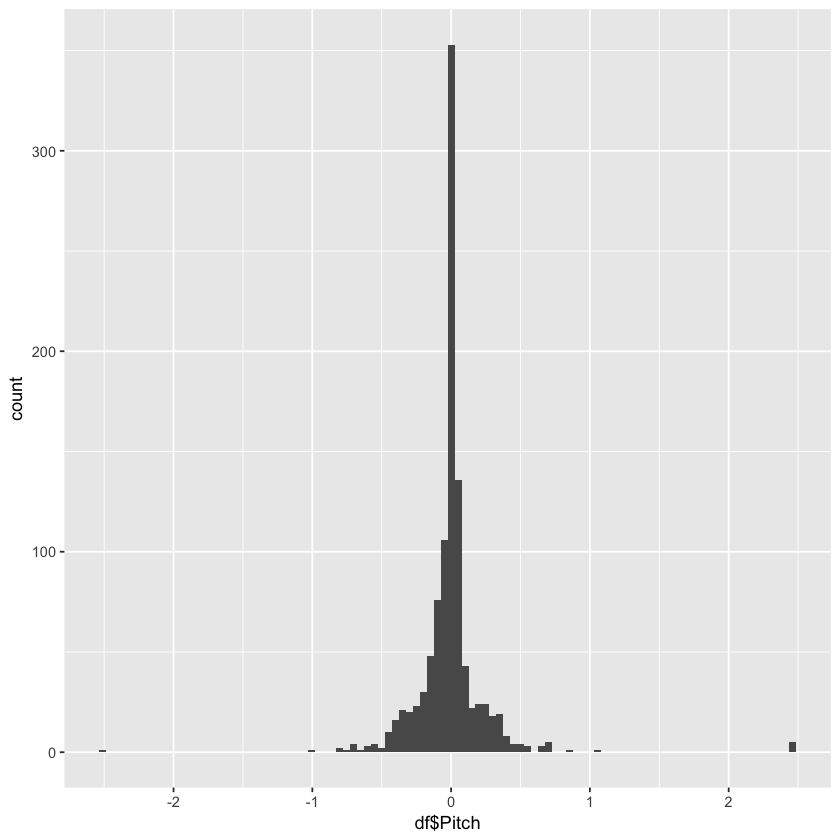

In [24]:
summary(df$Pitch)
p <- qplot(df$Pitch, geom="histogram", bins=100)
print(p)

In [25]:
df$Pitch <- sapply(df$Pitch, FUN=pryr::partial(thresholdOrIdentity, "<", 1))
df$Pitch <- sapply(df$Pitch, FUN=pryr::partial(thresholdOrIdentity, ">", -1))
summary(df$Pitch)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.0000000 -0.0768700  0.0002488 -0.0097070  0.0403000  1.0000000 

# SteeringAngle

In [26]:
df$SteeringAngle <- sapply(df$SteeringAngle, FUN=pryr::partial(thresholdOrIdentity, "<", 180))
df$SteeringAngle <- sapply(df$SteeringAngle, FUN=pryr::partial(thresholdOrIdentity, ">", -180))
summary(df$SteeringAngle)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-180.000    1.400    3.000    3.184    4.900  180.000 

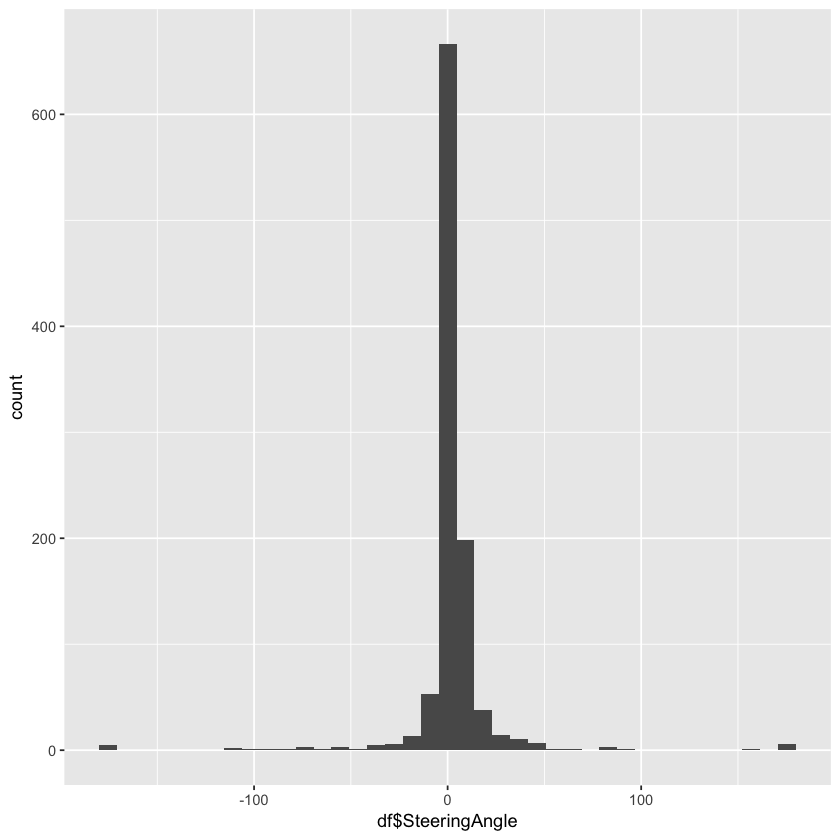

In [27]:
p <- qplot(df$SteeringAngle, geom="histogram", bins=40, xlim = c(-180, 180))
print(p)

# AheadDistance

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.2    15.3    25.5    40.4    90.0   115.2 

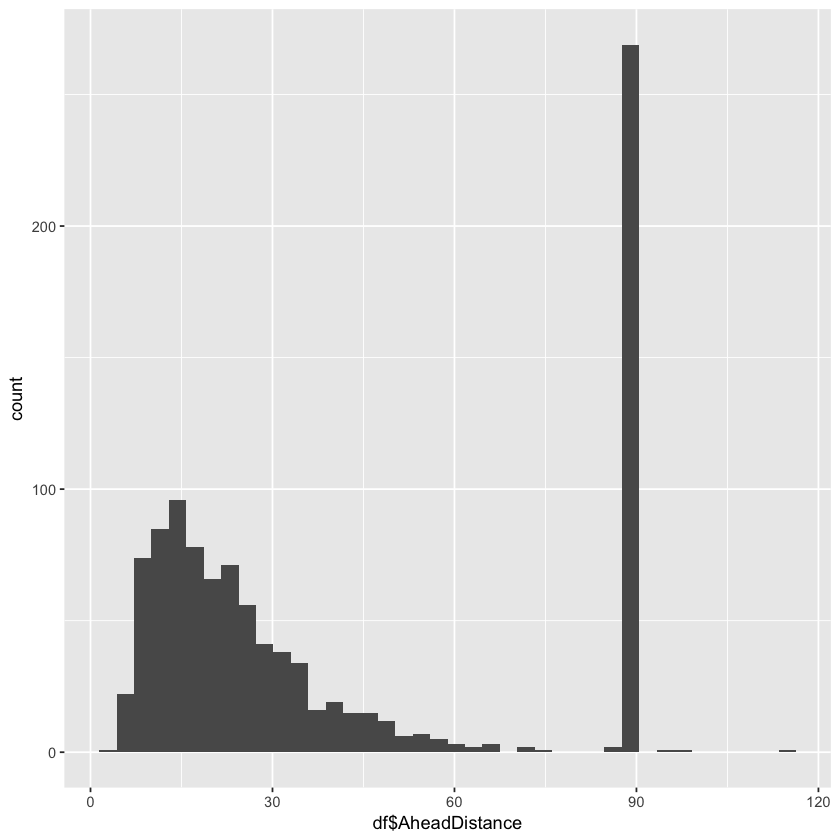

In [28]:
summary(df$AheadDistance)
p <- qplot(df$AheadDistance, geom="histogram", bins=40)
print(p)

In [38]:
df$AheadDistance <- sapply(df$AheadDistance, FUN=pryr::partial(thresholdOrIdentity, "<", 90))
summary(df$AheadDistance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.20   15.30   25.50   40.37   90.00   90.00 

# Speed

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.89   22.93   35.56   36.78   46.45  105.80 

Saving 7 x 7 in image


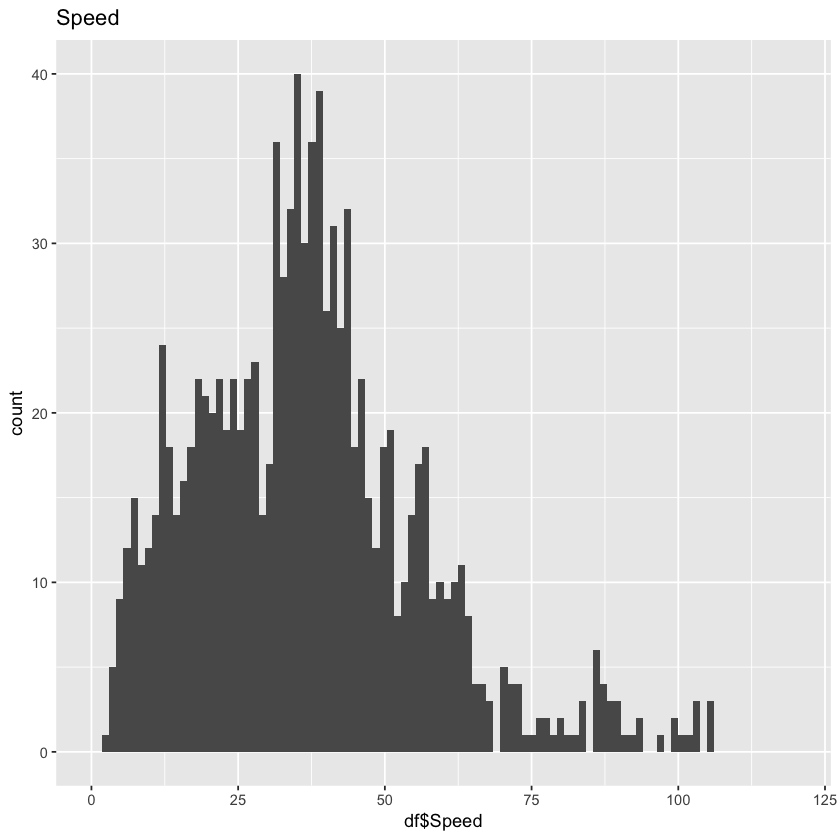

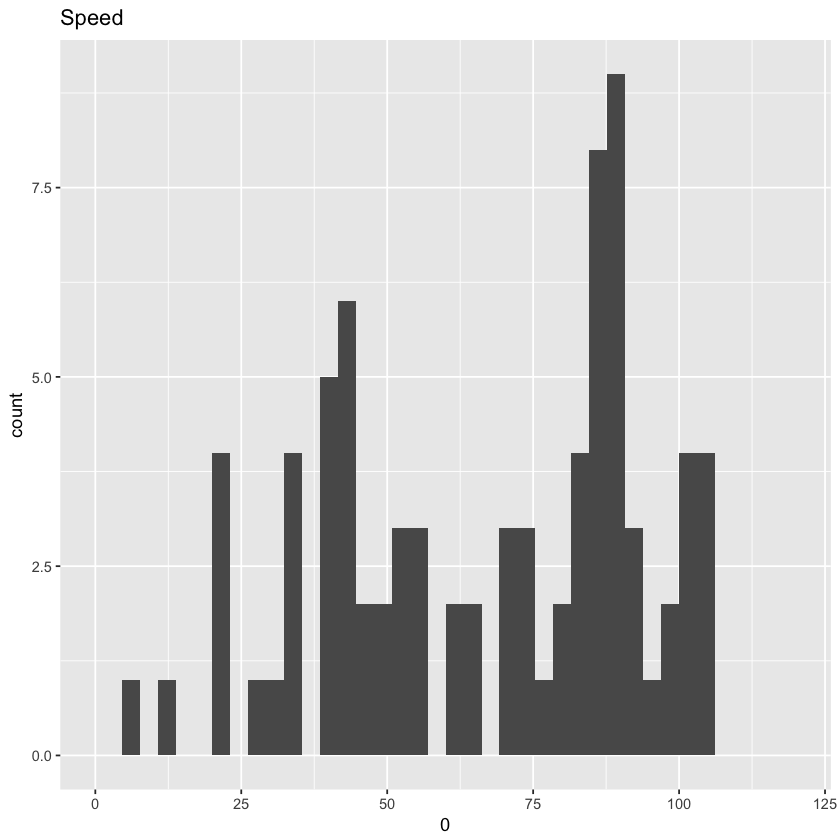

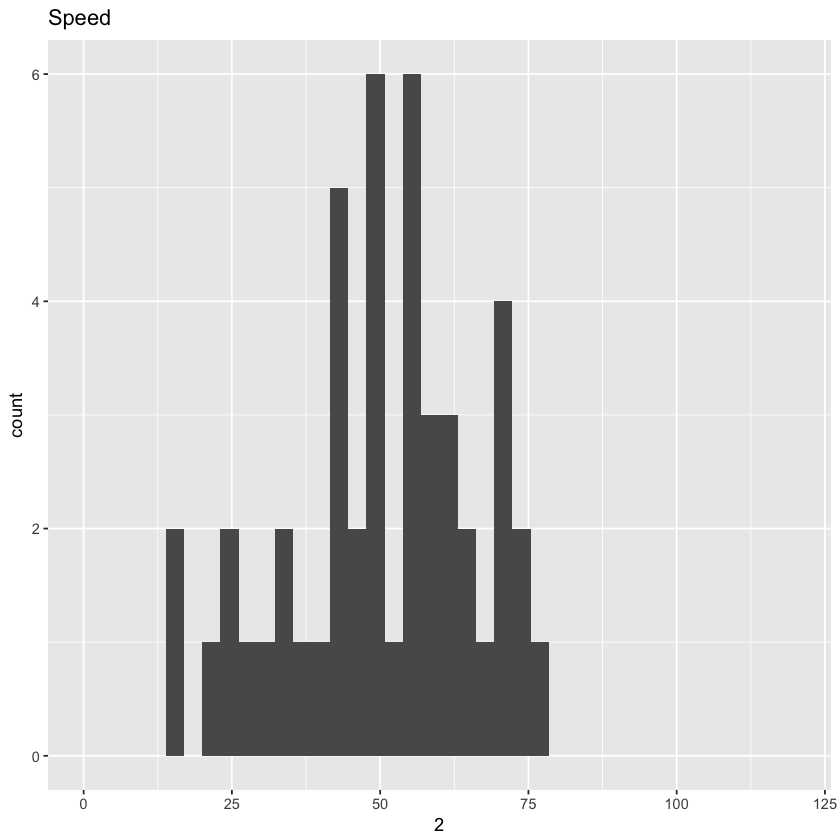

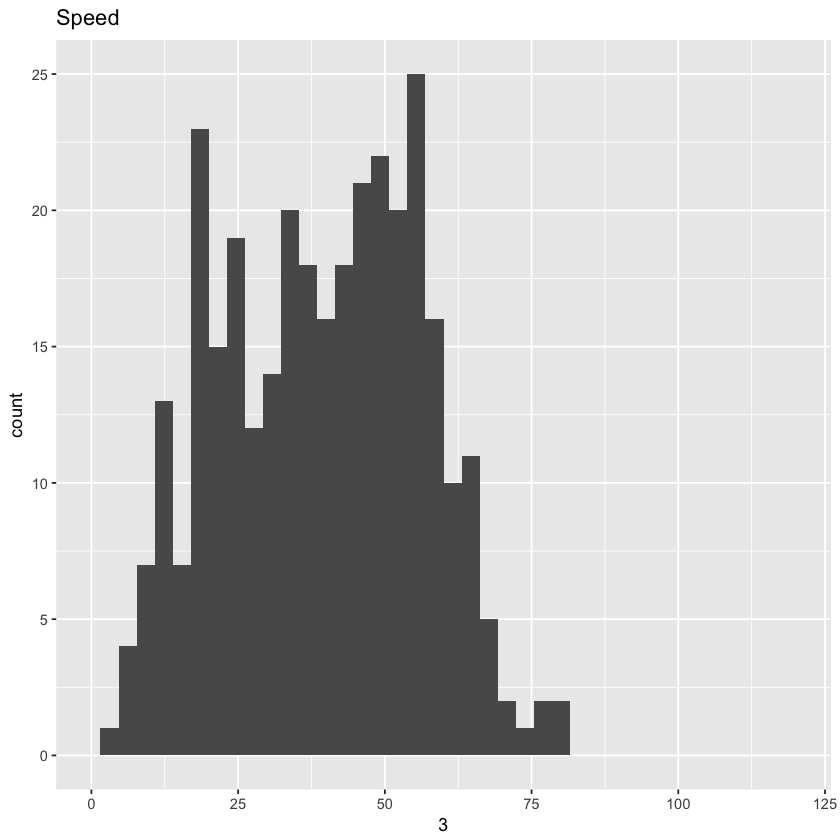

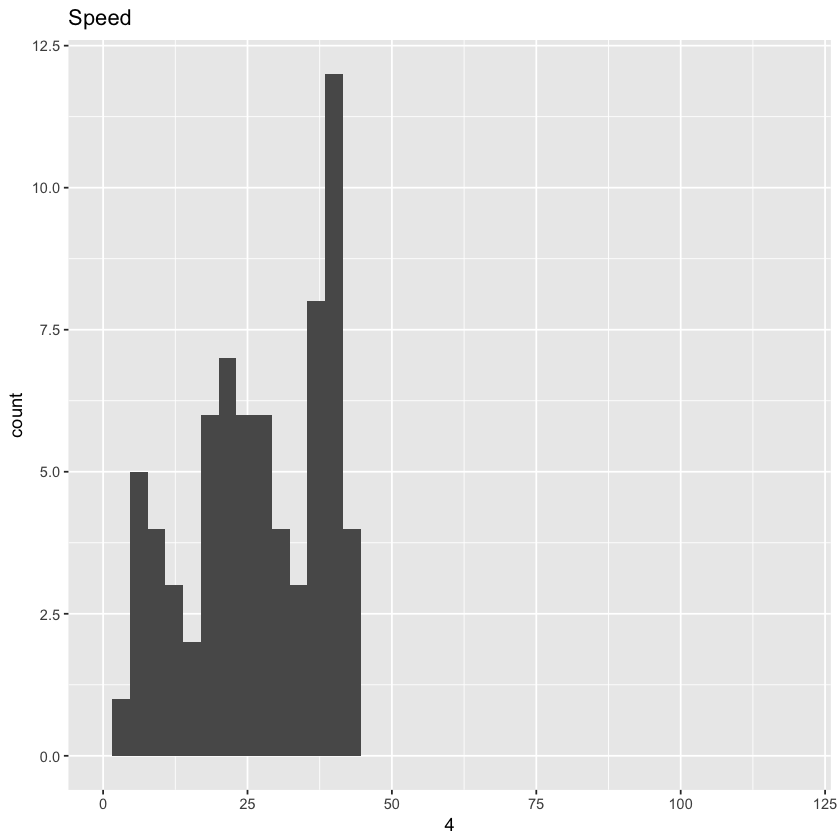

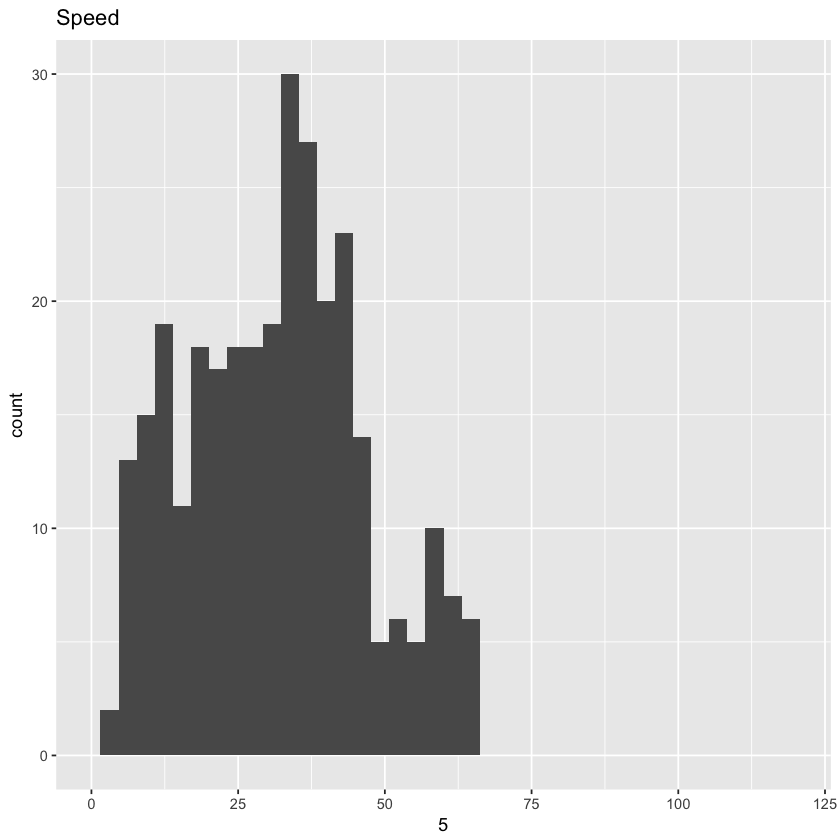

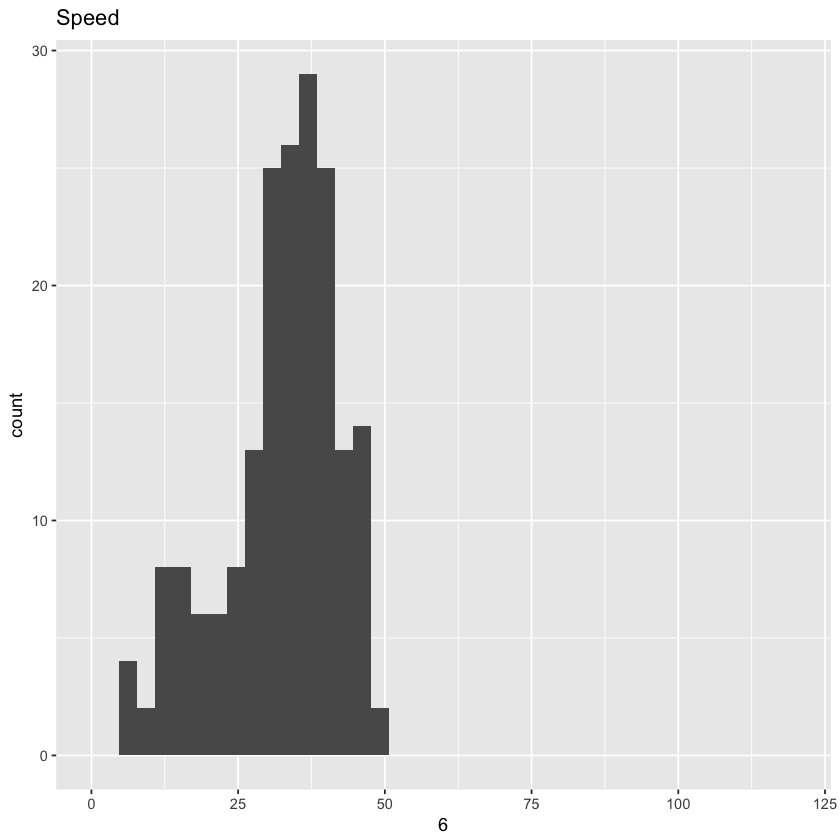

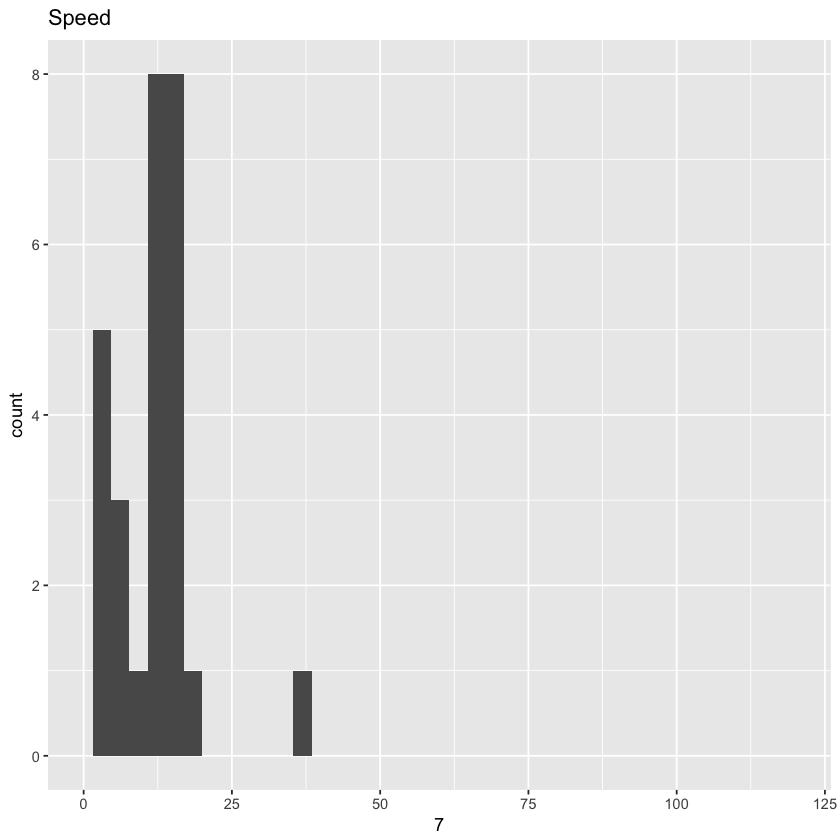

In [30]:
summary(df$Speed)
p1 <- qplot(df$Speed, geom="histogram", bins=100, xlim=c(0, 120), main="Speed")
ggsave(p1, file="AllSpeed.png")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(Speed), geom="histogram", bins=40, xlim=c(0, 120), xlab=i, main="Speed")
    # ggsave(plot=px, file=L(f="Speed-%d.png", i))
    print(px)  
}

# AverageVelocity

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0357  12.4300  22.4300  26.1300  32.8900 102.1000 

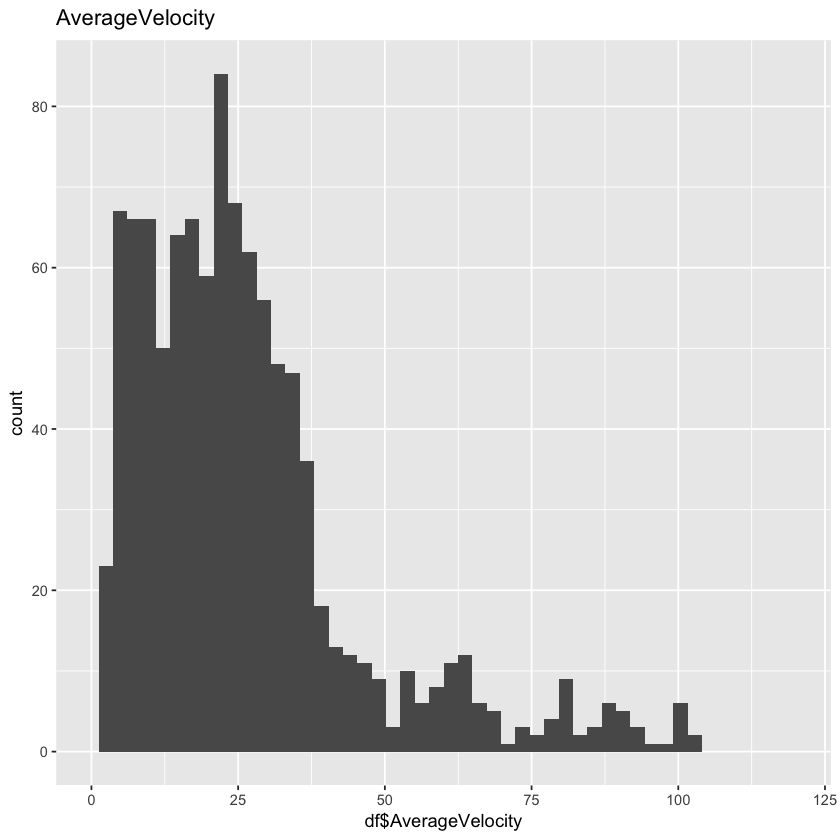

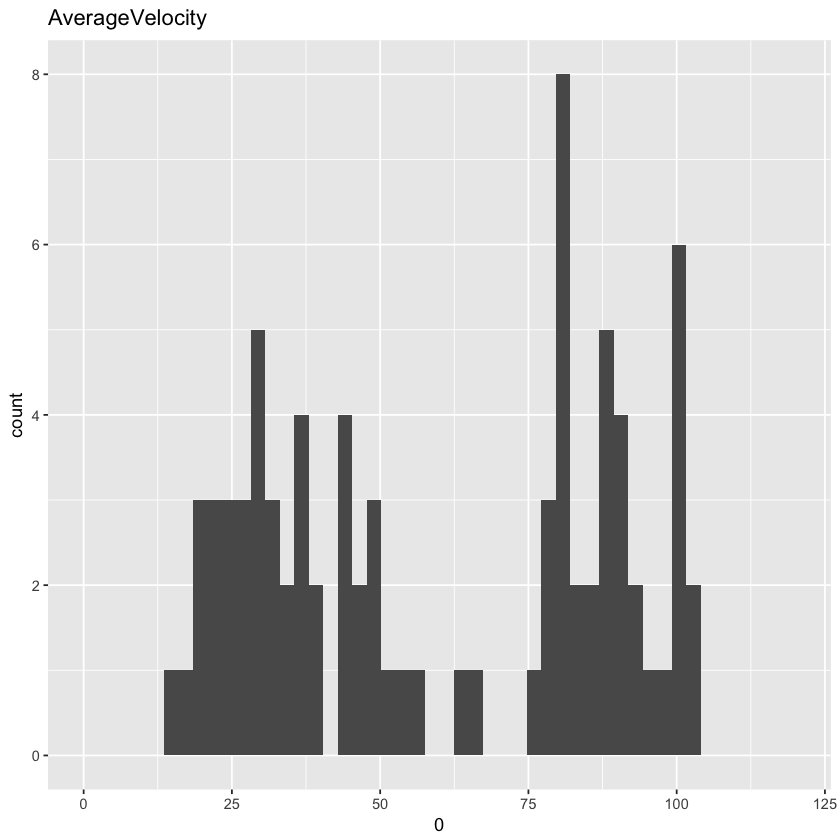

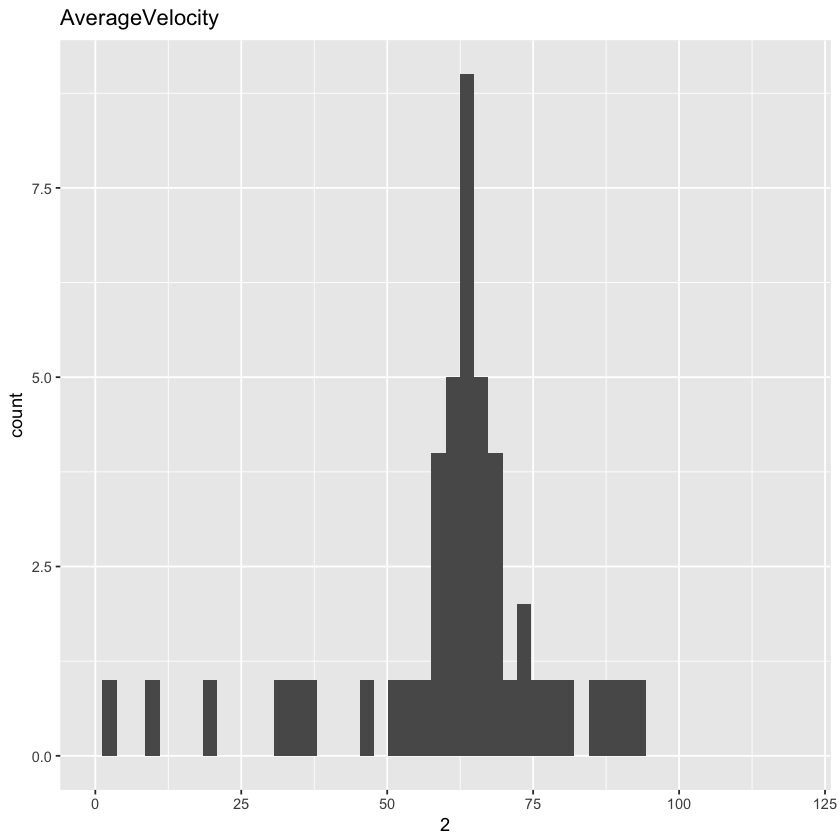

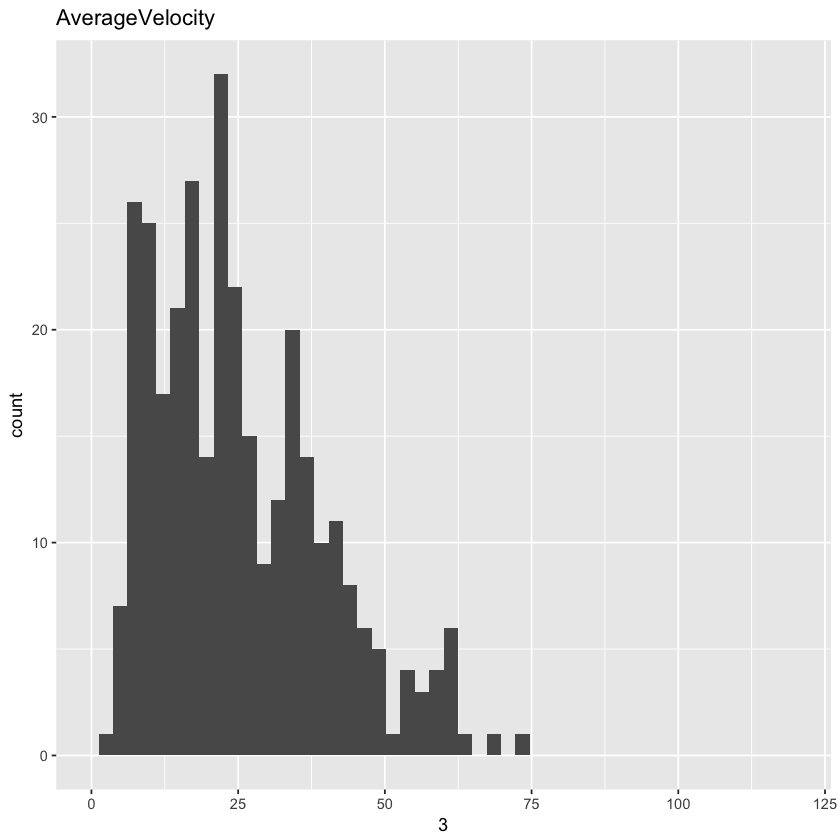

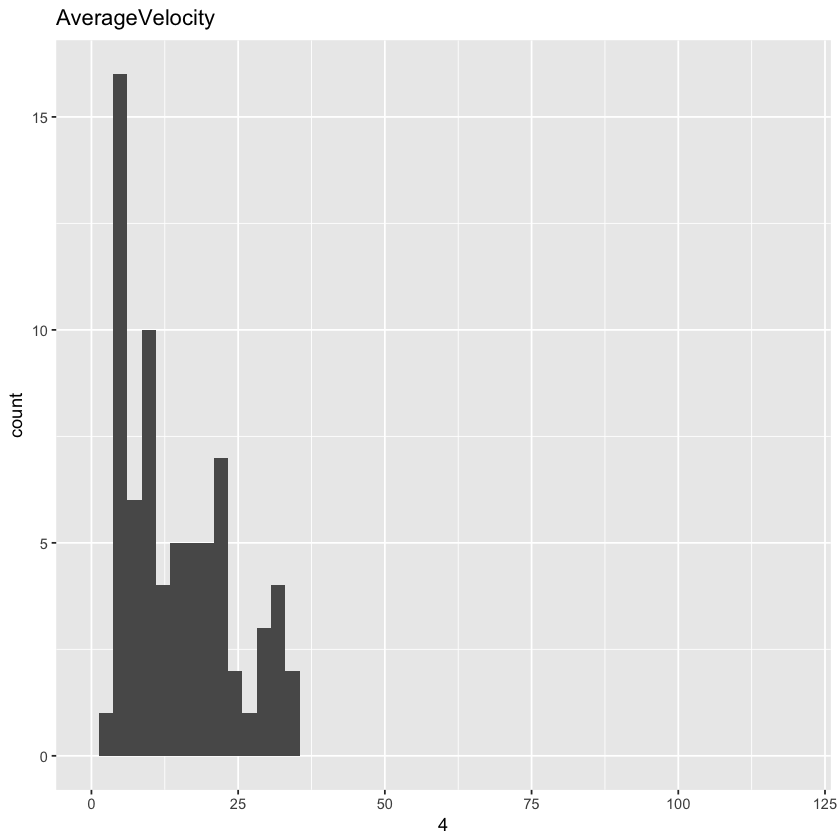

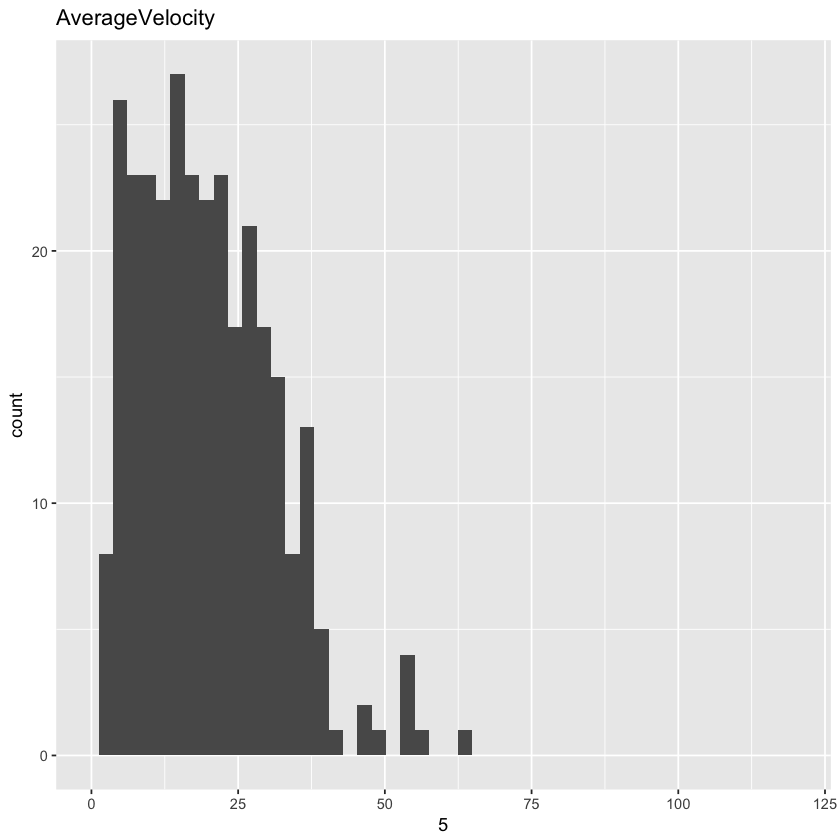

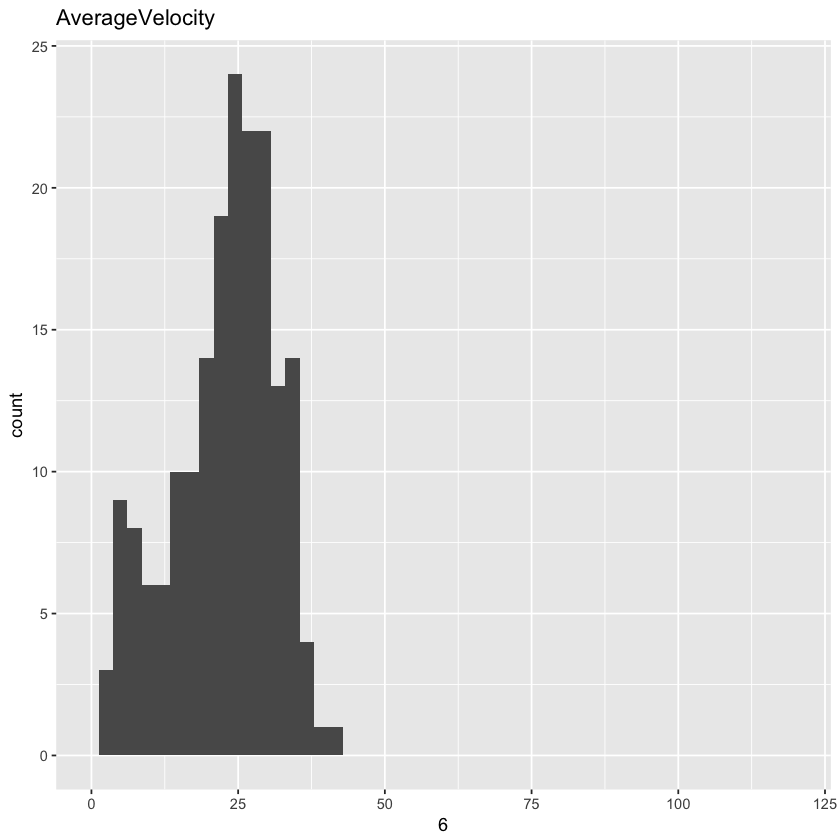

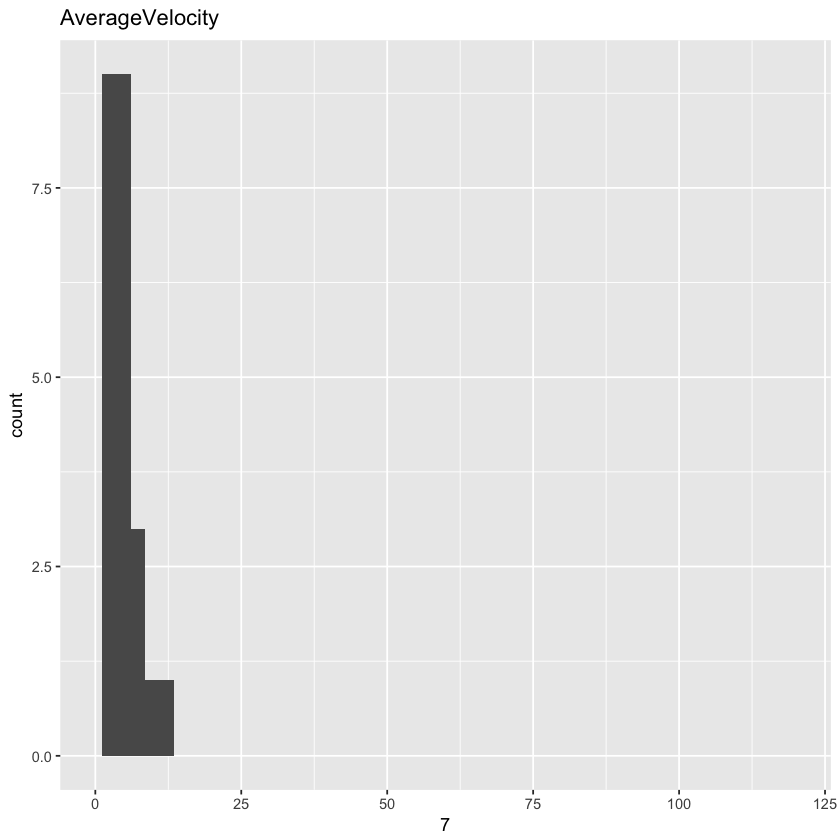

In [31]:
summary(df$AverageVelocity)
p1 <- qplot(df$AverageVelocity, geom="histogram", bins=50, xlim=c(0, 120), main="AverageVelocity")
# ggsave(p1, file="AllAverageVelocity.png")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(AverageVelocity), geom="histogram", bins=50, xlim=c(0, 120), xlab=i, main="AverageVelocity")
    # ggsave(plot=px, file=L(f="AverageVelocity-%d.png", i))
    print(px)  
}

# MaxSpeed

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.89   37.68   44.69   47.75   57.76  106.40 

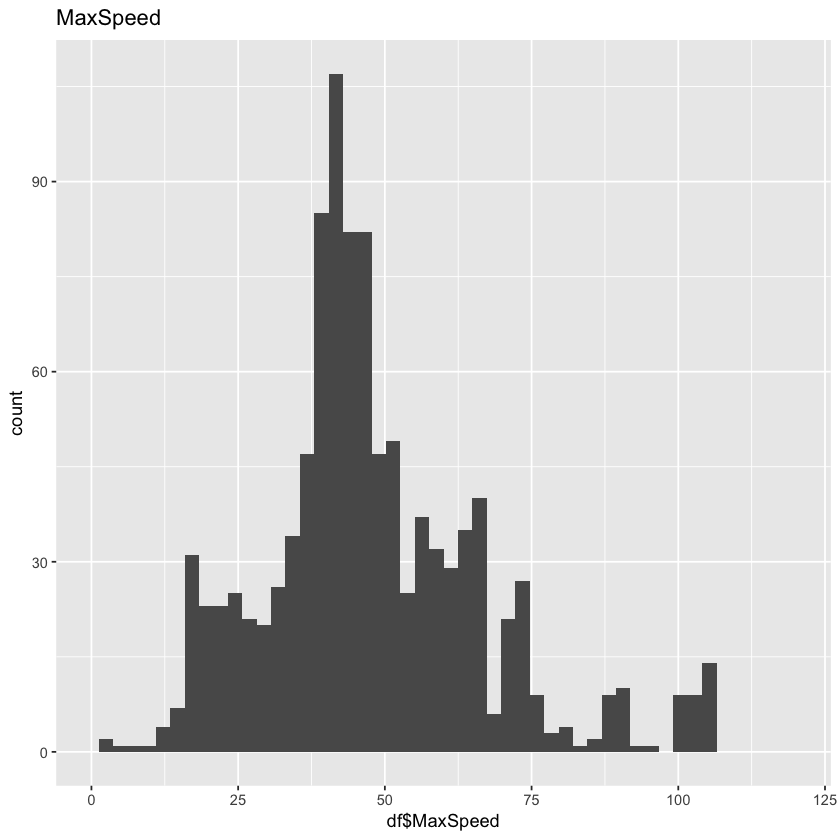

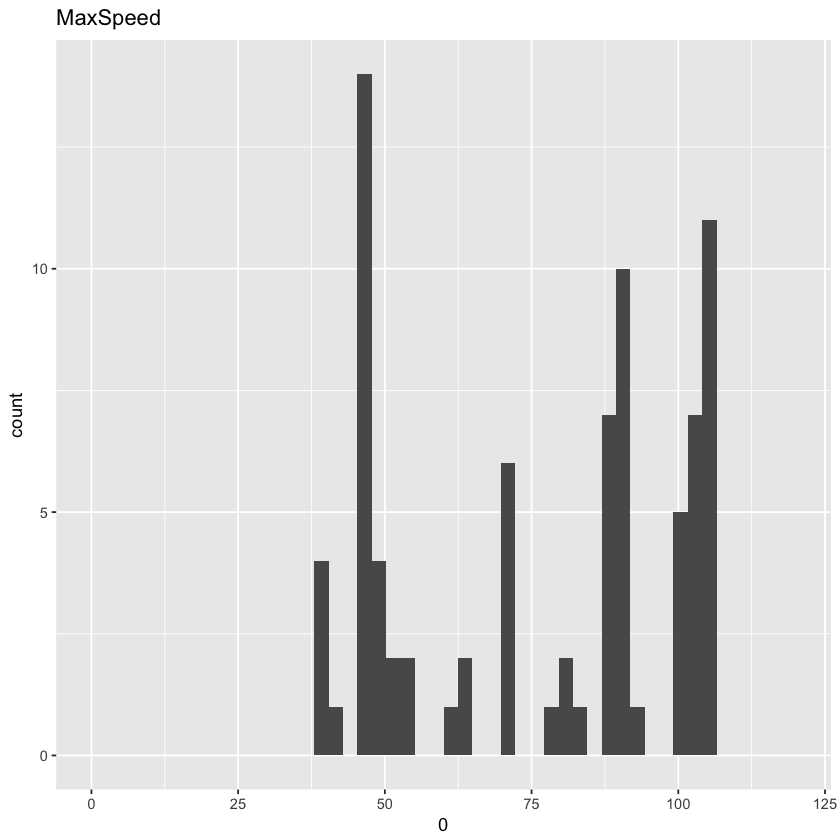

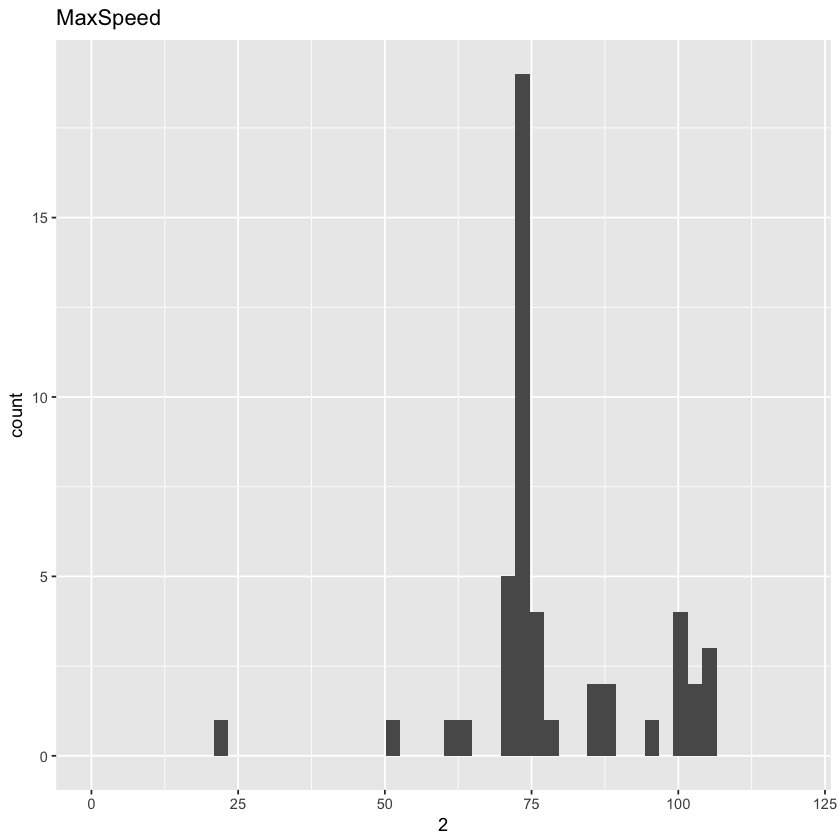

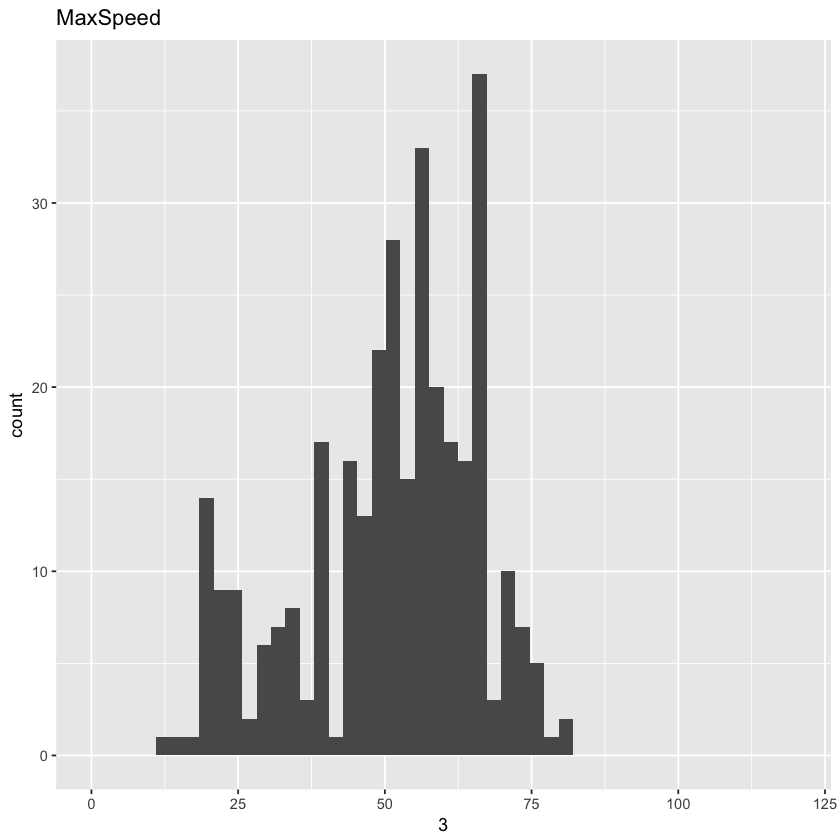

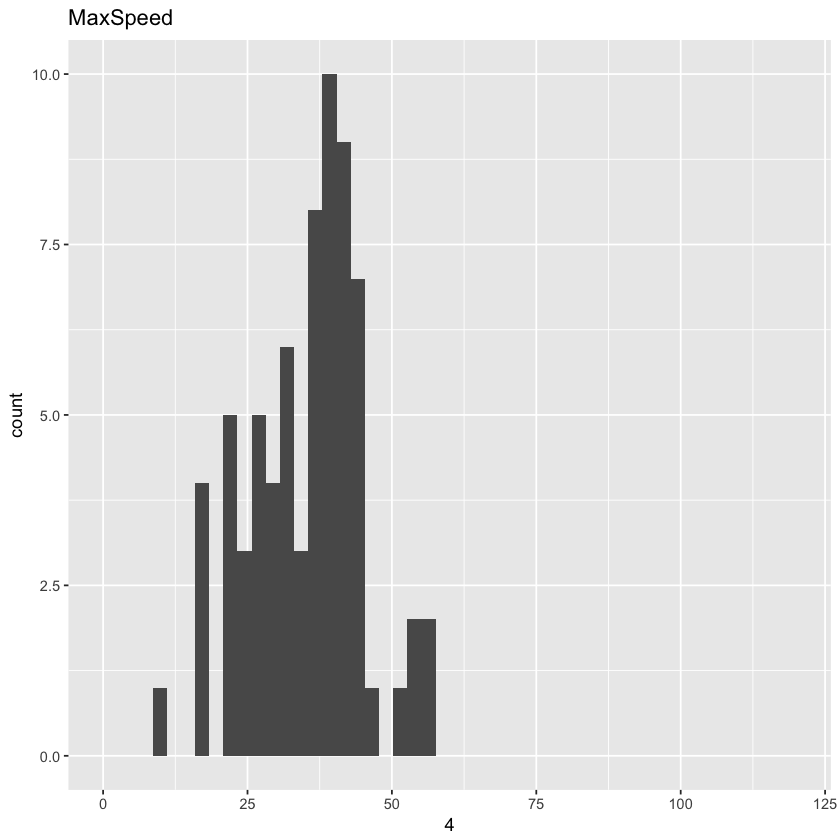

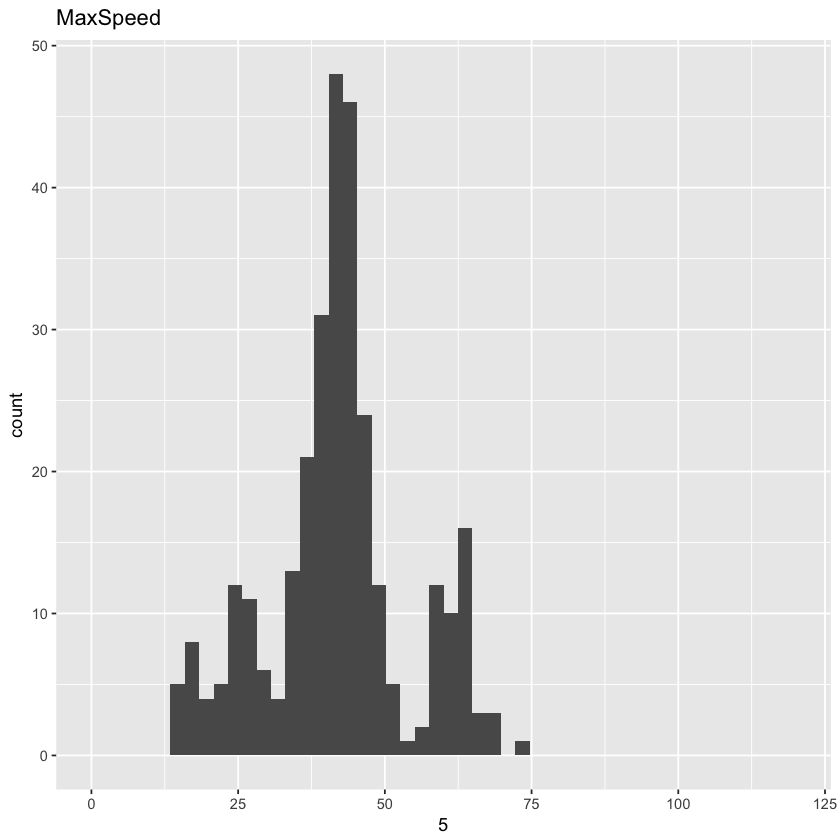

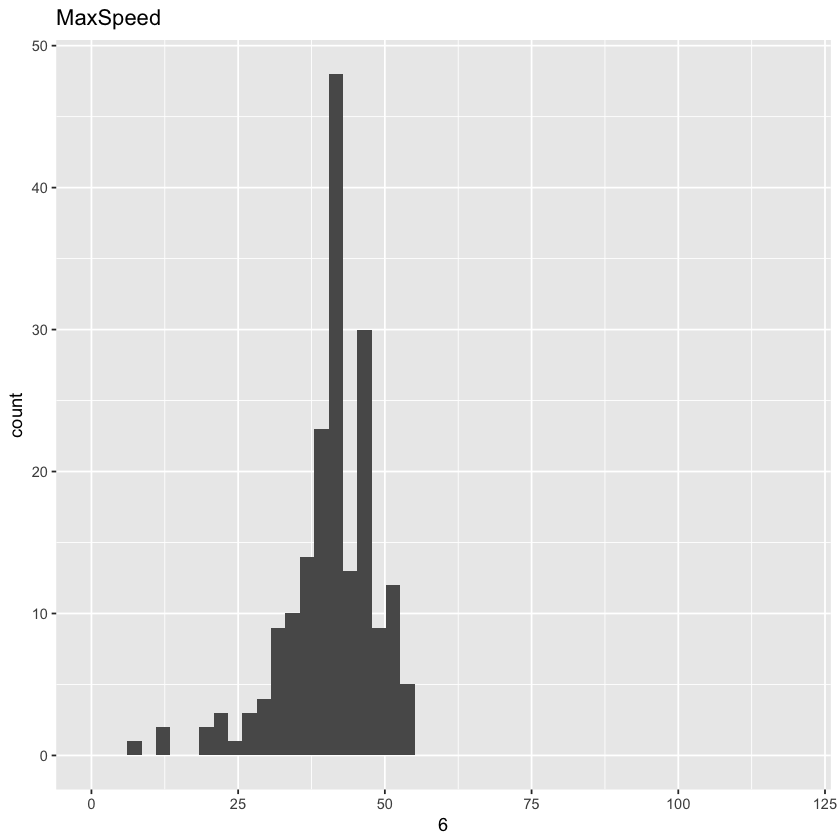

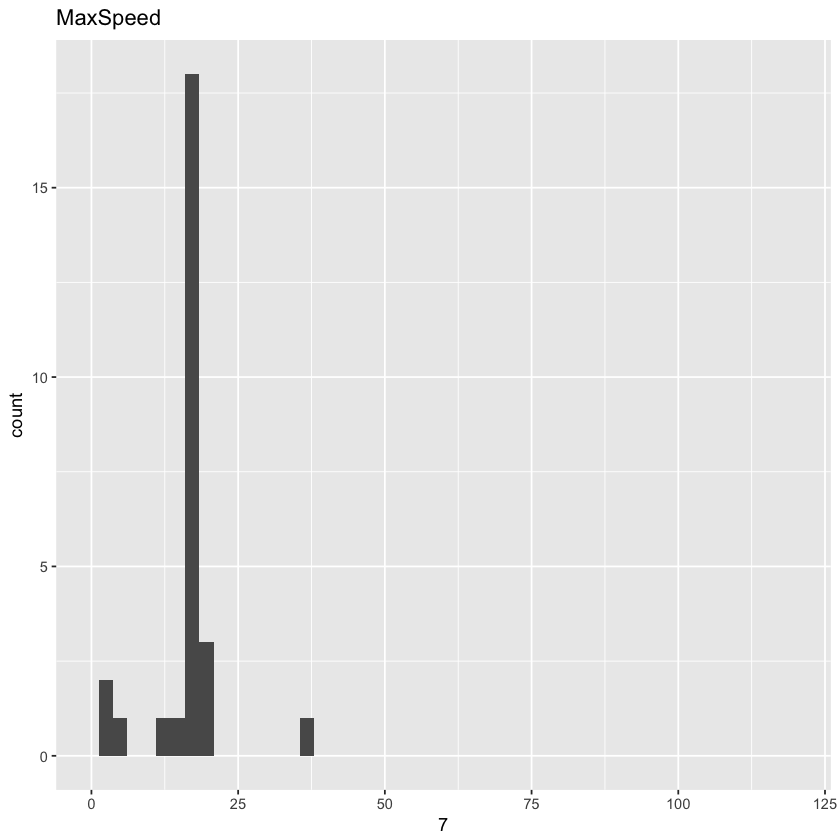

In [32]:
summary(df$MaxSpeed)
p1 <- qplot(df$MaxSpeed, geom="histogram", bins=50, xlim=c(0, 120), main="MaxSpeed")
# ggsave(p1, file="AllMaxSpeed.png")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(MaxSpeed), geom="histogram", bins=50, xlim=c(0, 120), xlab=i, main="MaxSpeed")
    # ggsave(plot=px, file=L(f="MaxSpeed-%d.png", i))
    print(px)  
}

# Min Speed

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   7.044   0.000  98.820 

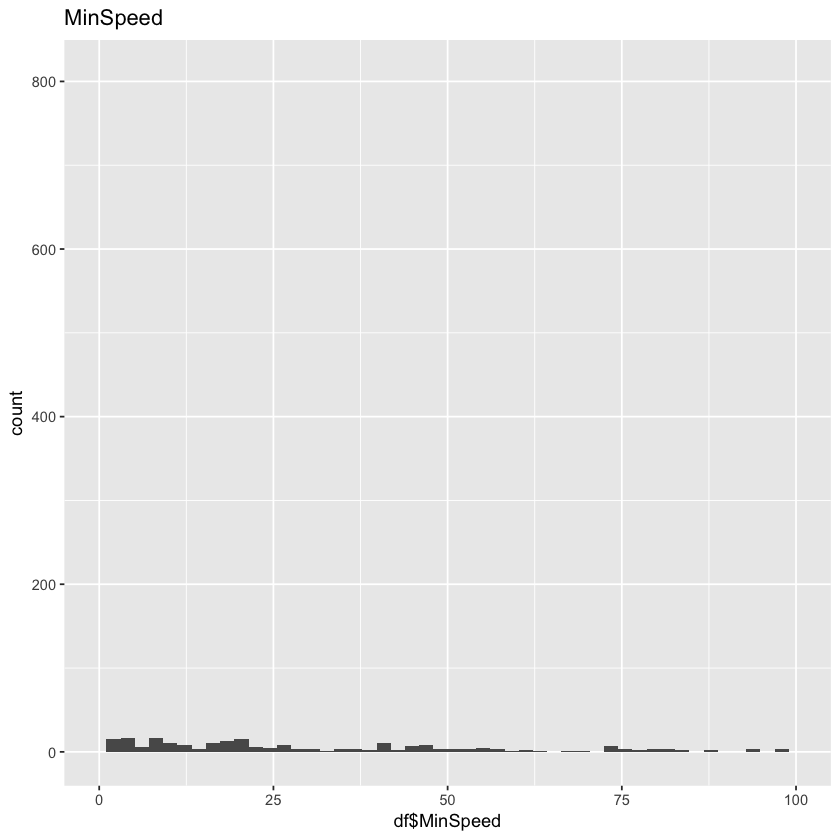

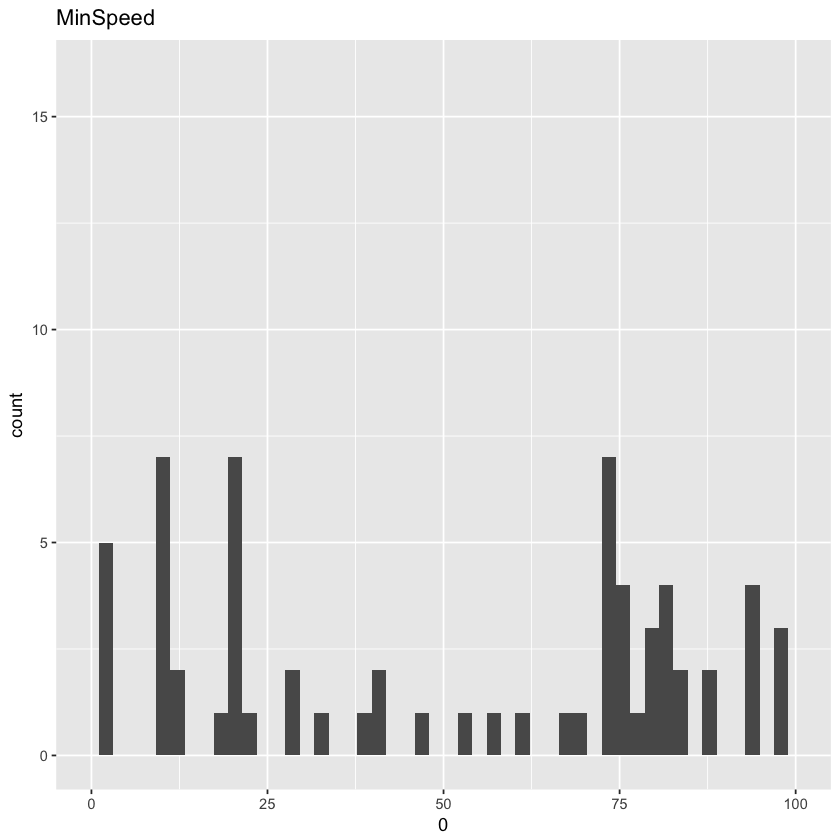

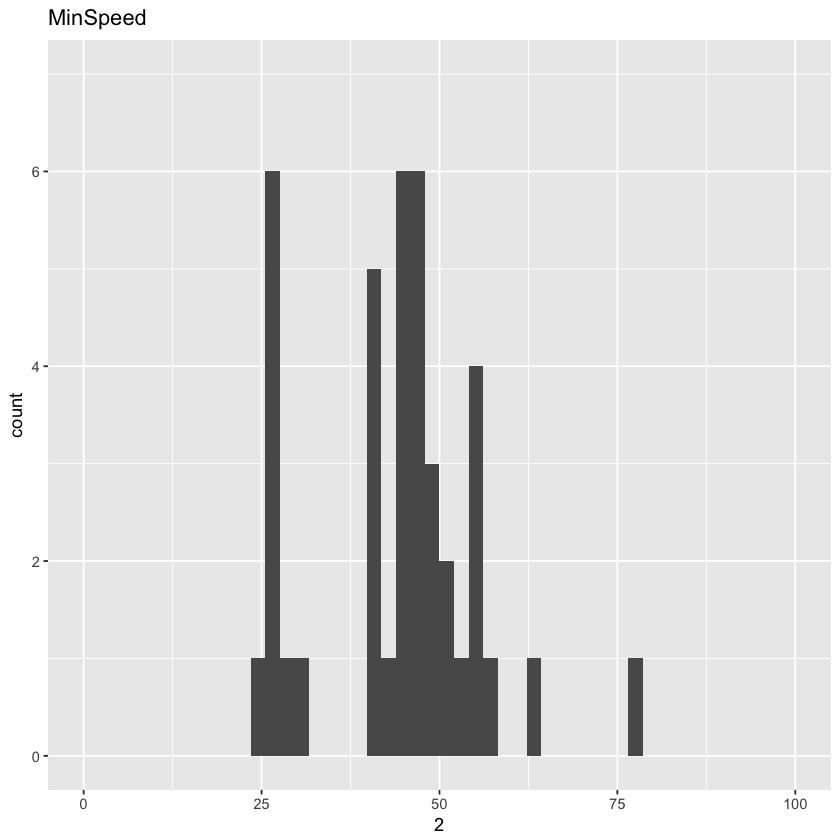

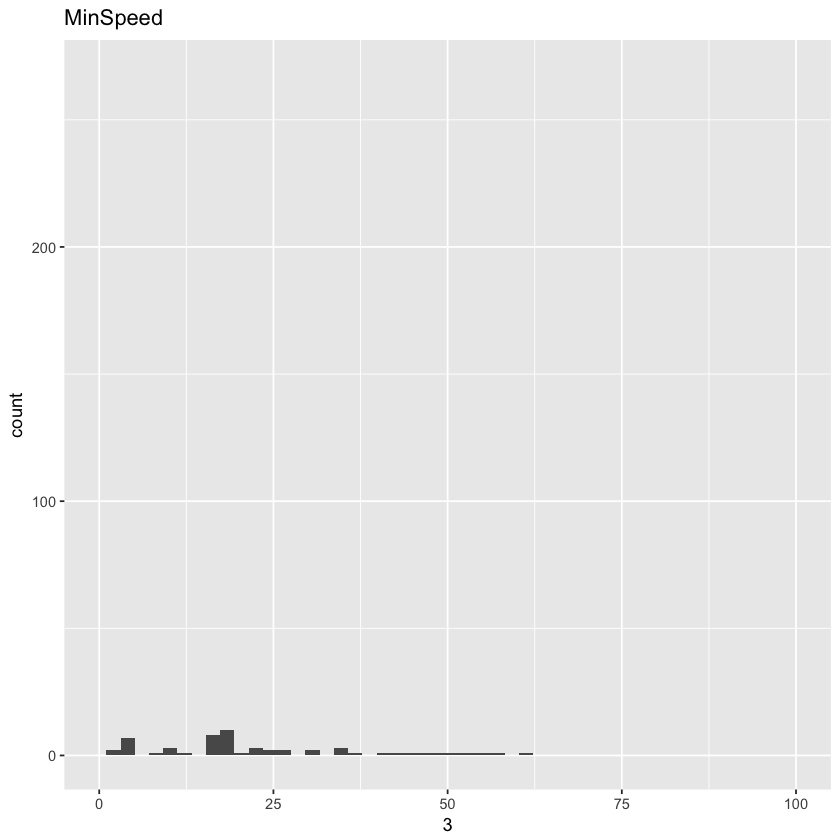

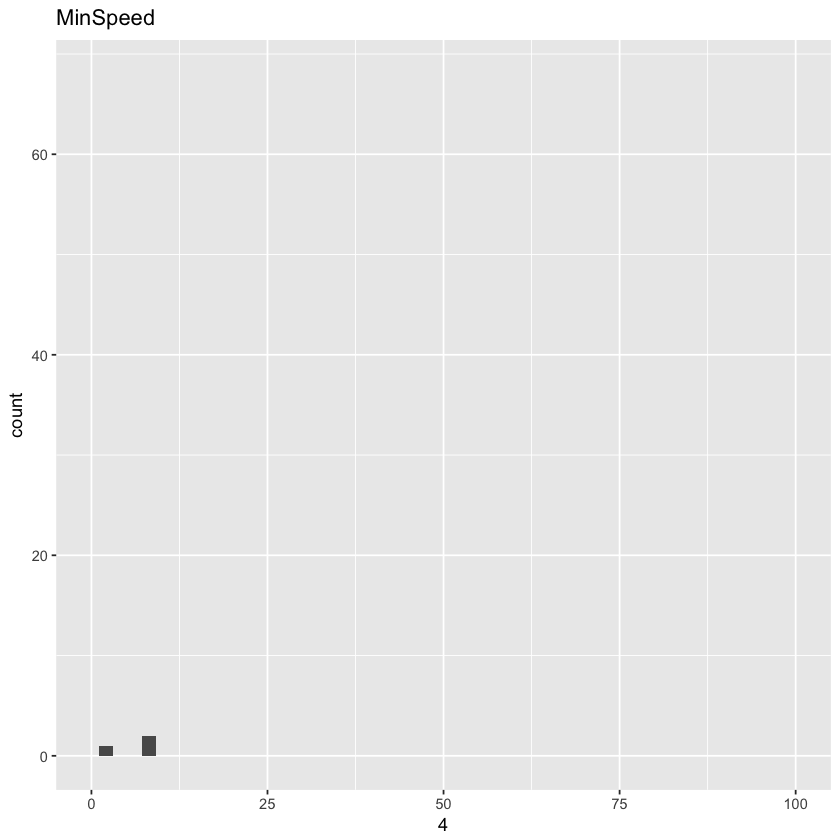

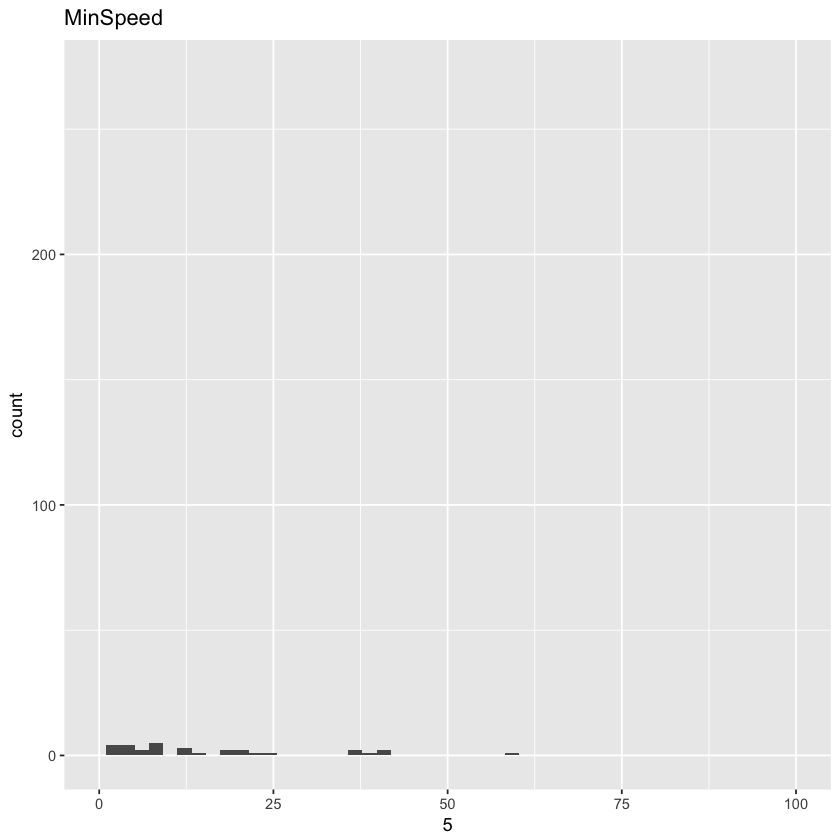

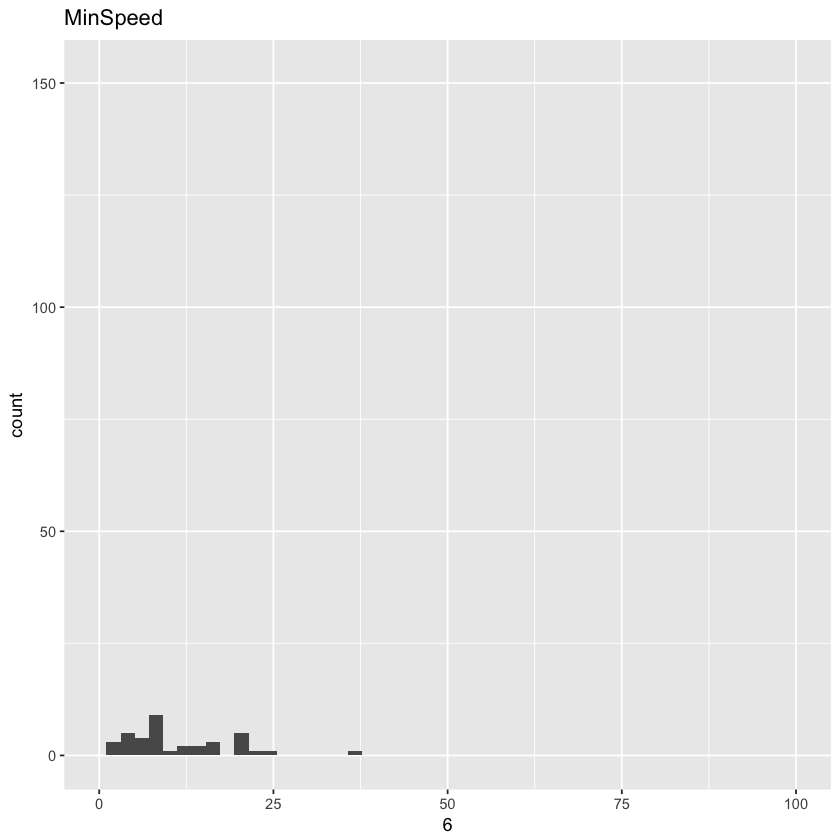

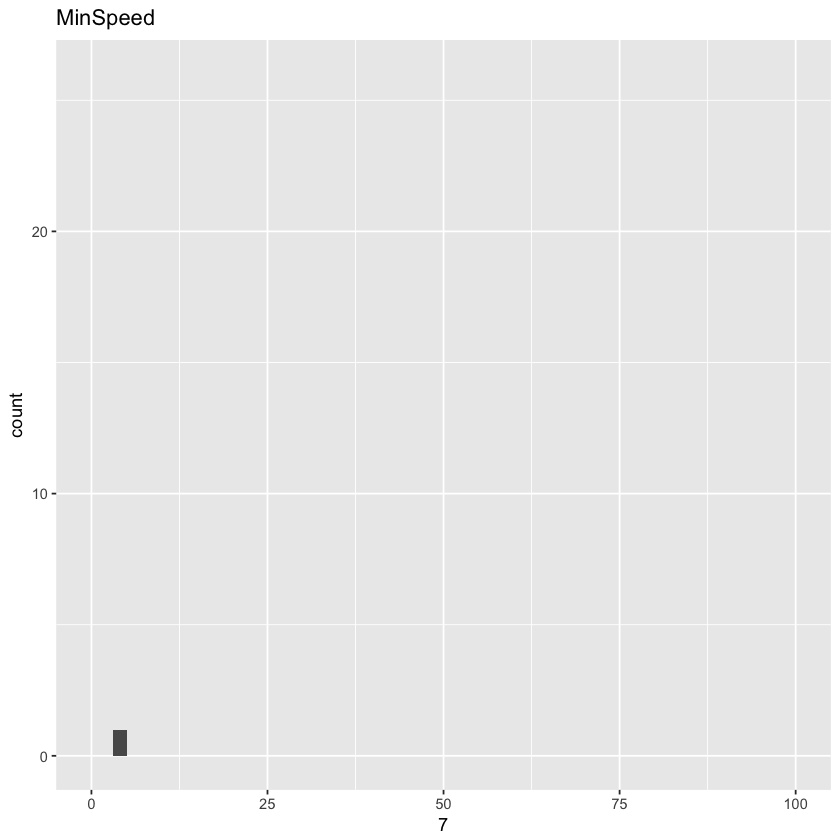

In [33]:
summary(df$MinSpeed)
p1 <- qplot(df$MinSpeed, geom="histogram", bins=50, xlim=c(0, 100), main="MinSpeed")
# ggsave(p1, file="AllMinSpeed.png")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(MinSpeed), geom="histogram", xlim=c(0, 100), bins=50, xlab=i, main="MinSpeed")
    # ggsave(plot=px, file=L(f="MinSpeed-%d.png", i))
    print(px)  
}

# TimeToCollision

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.177e+15 -6.870e+02  1.160e+02 -1.129e+12  6.570e+02  1.730e+05 

Warning message:
“Removed 956 rows containing non-finite values (stat_bin).”Warning message:
“Removed 78 rows containing non-finite values (stat_bin).”

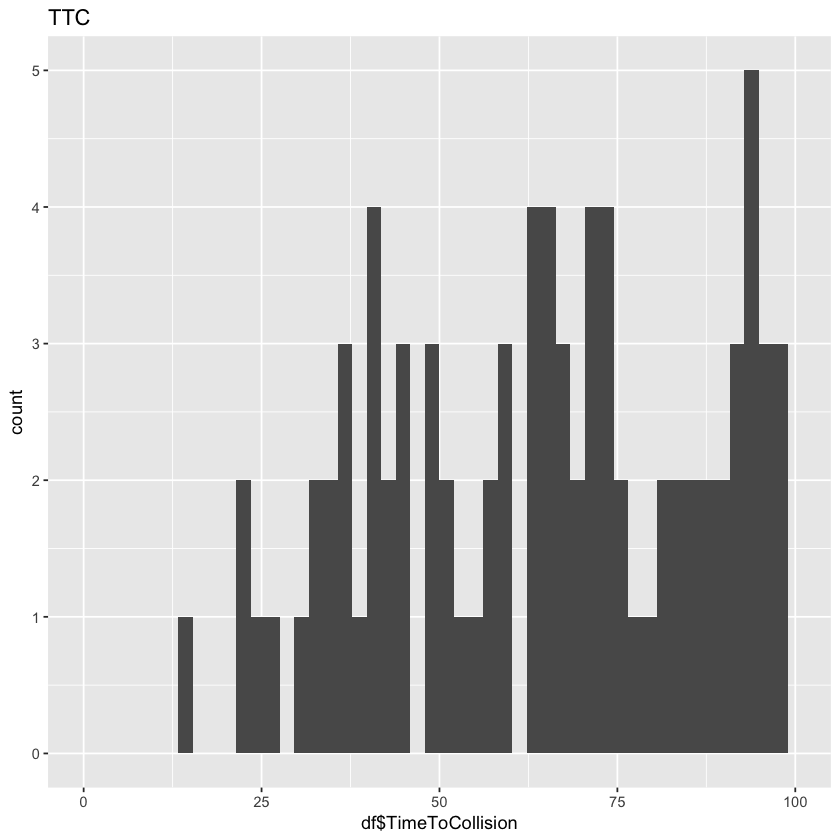

Warning message:
“Removed 42 rows containing non-finite values (stat_bin).”

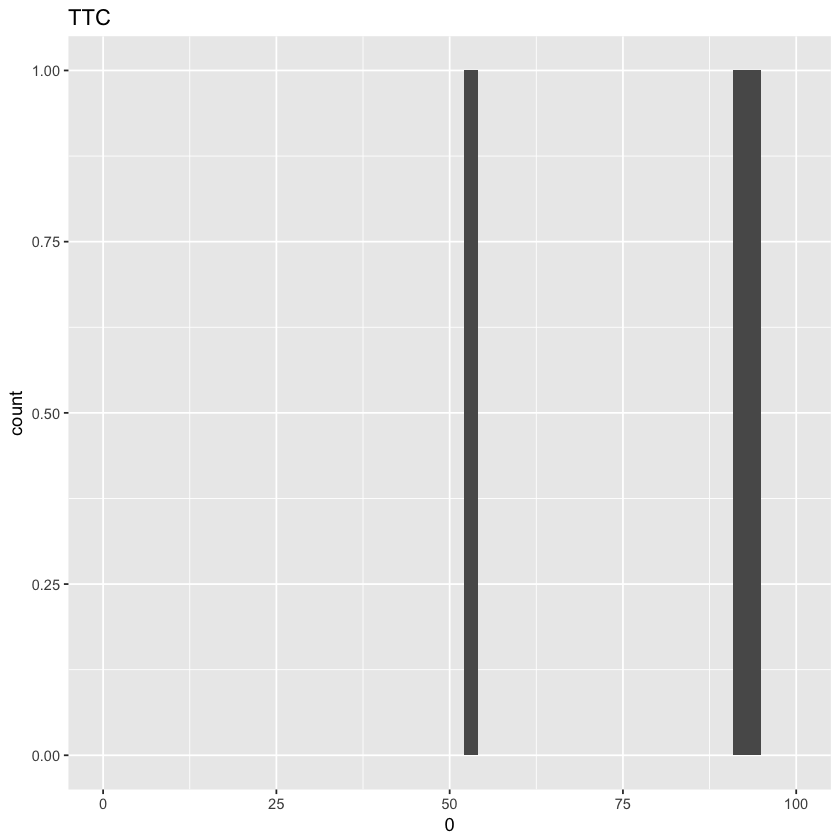

Warning message:
“Removed 292 rows containing non-finite values (stat_bin).”

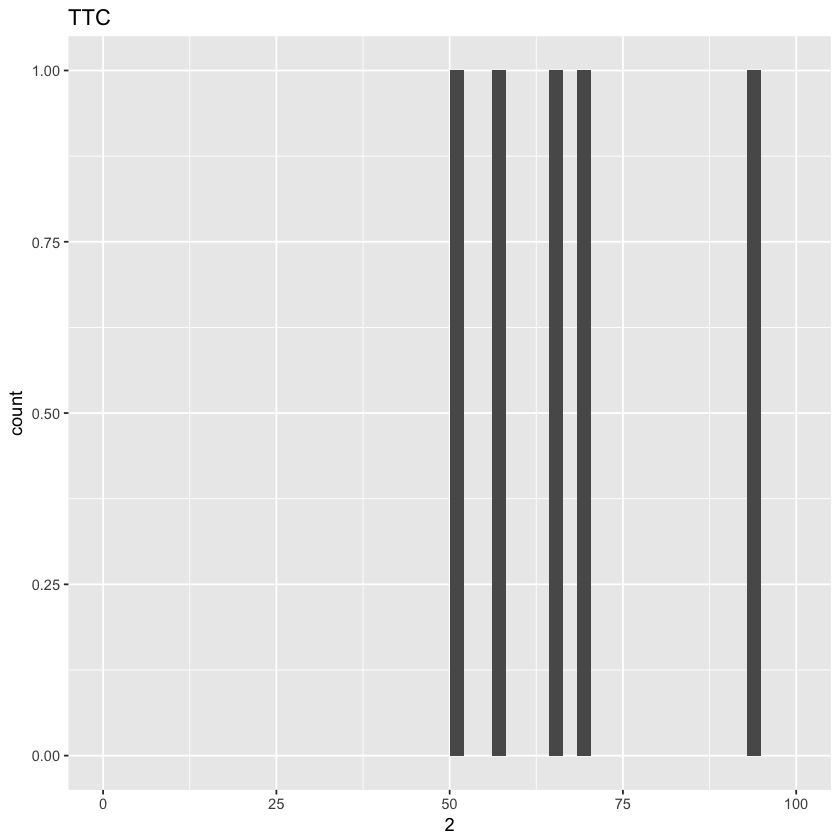

Warning message:
“Removed 64 rows containing non-finite values (stat_bin).”

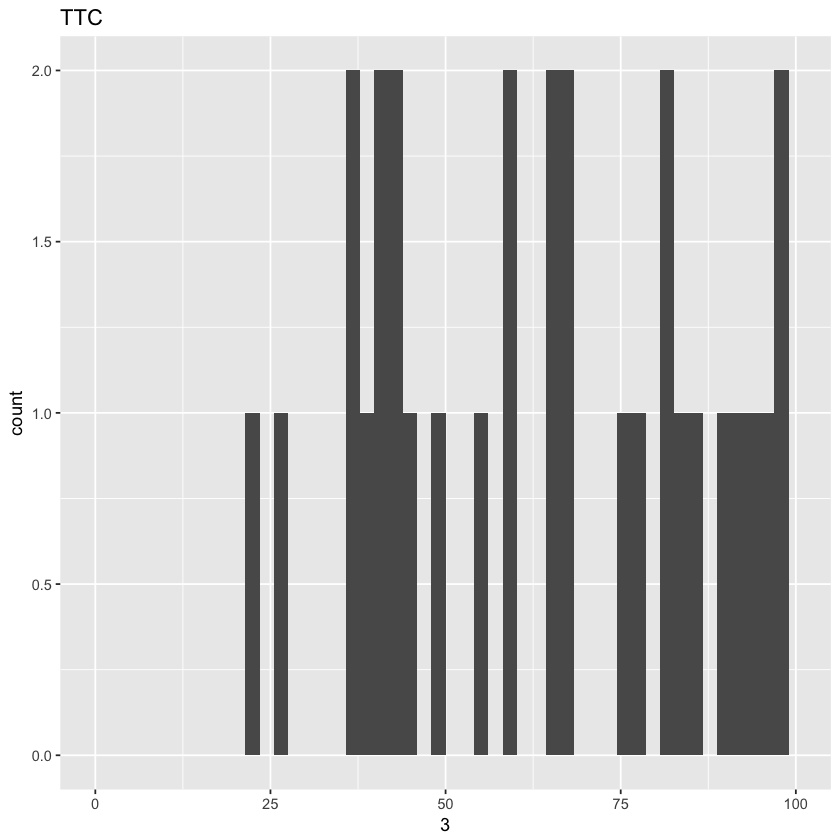

Warning message:
“Removed 278 rows containing non-finite values (stat_bin).”

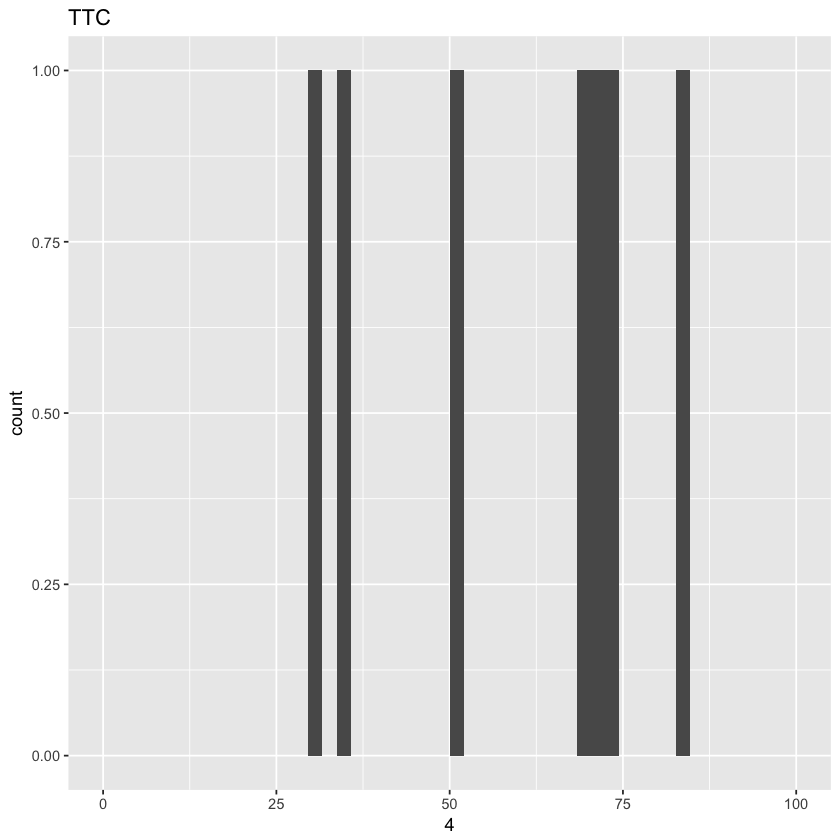

Warning message:
“Removed 177 rows containing non-finite values (stat_bin).”

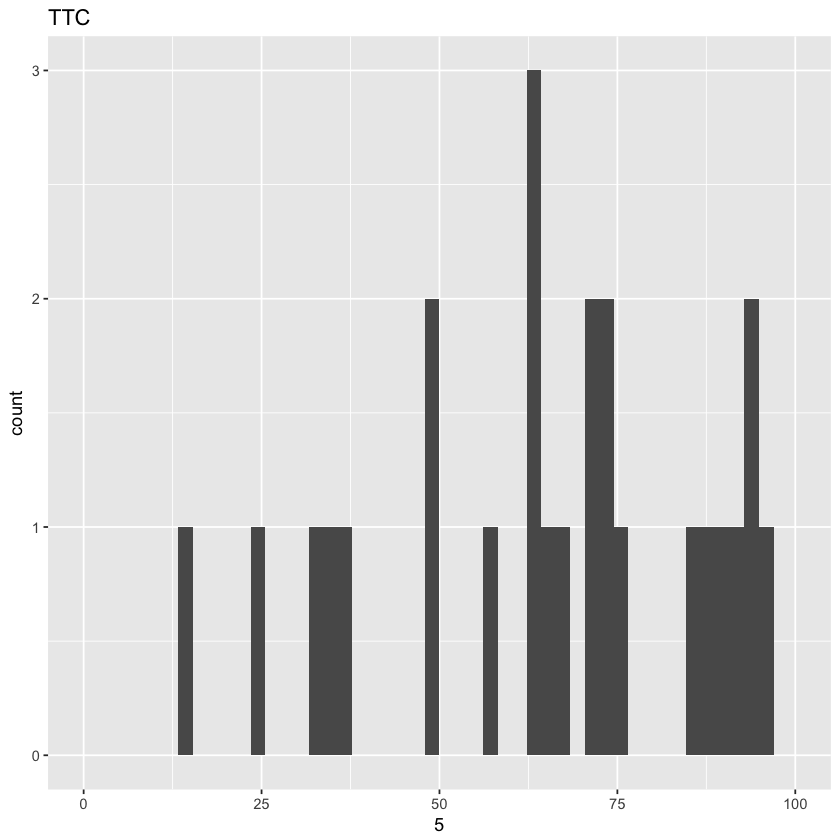

Warning message:
“Removed 25 rows containing non-finite values (stat_bin).”

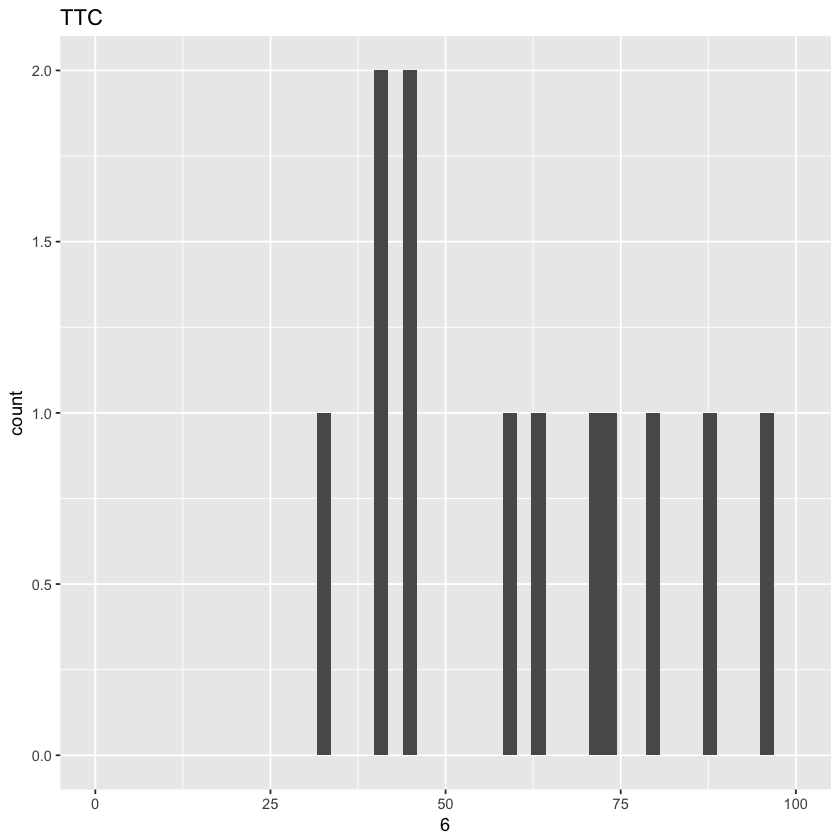

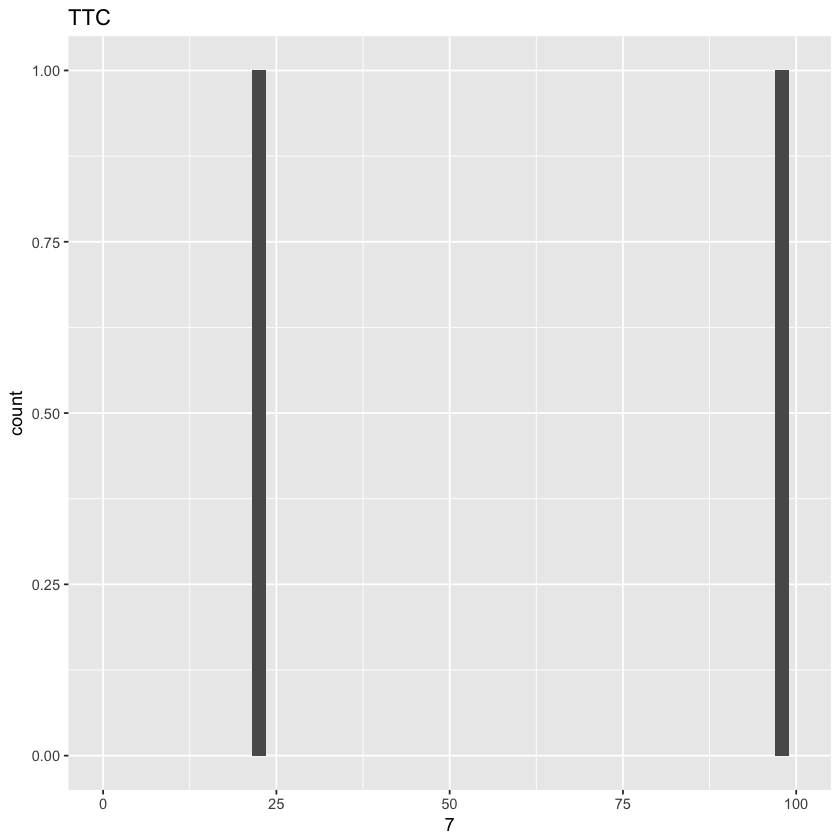

In [40]:
summary(df$TimeToCollision)
p1 <- qplot(df$TimeToCollision, geom="histogram", bins=50, xlim=c(0, 100), main="TTC")
# ggsave(p1, file="AllTTCpng")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(TimeToCollision), geom="histogram", xlim=c(0, 100), bins=50, xlab=i, main="TTC")
    # ggsave(plot=px, file=L(f="TTC-%d.png", i))
    print(px)  
}

# TimeHeadway

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.734   2.038   2.837   5.337   5.362 169.600 

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”

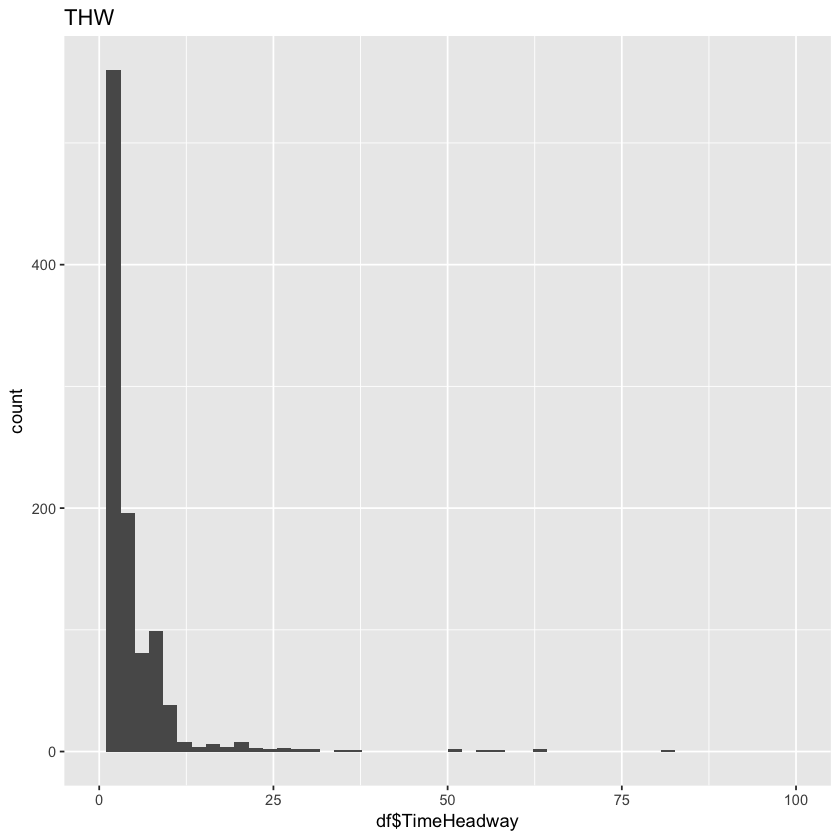

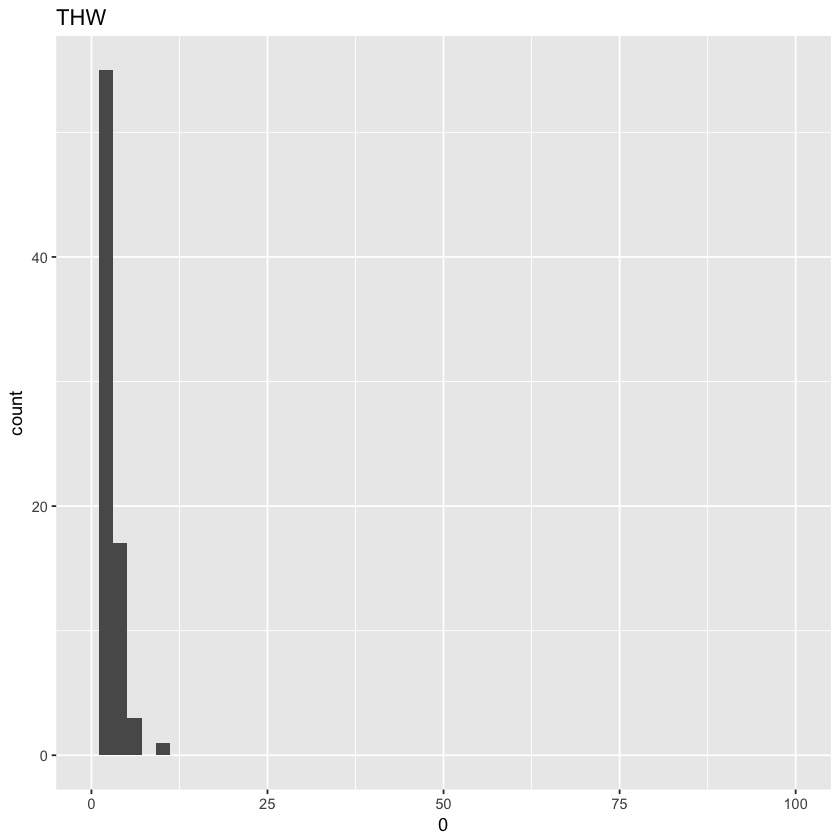

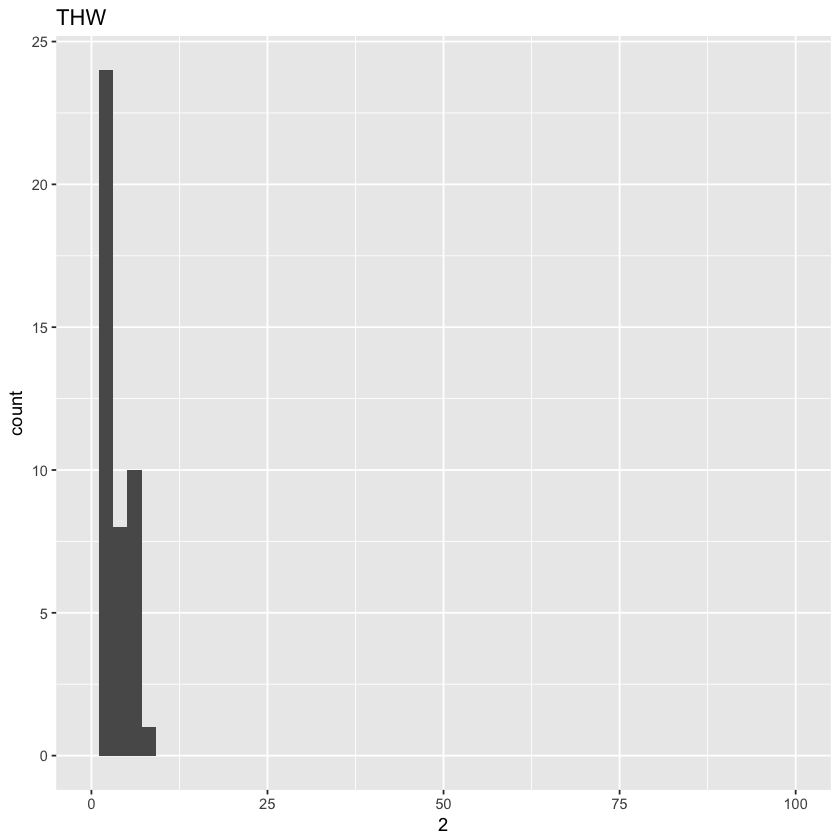

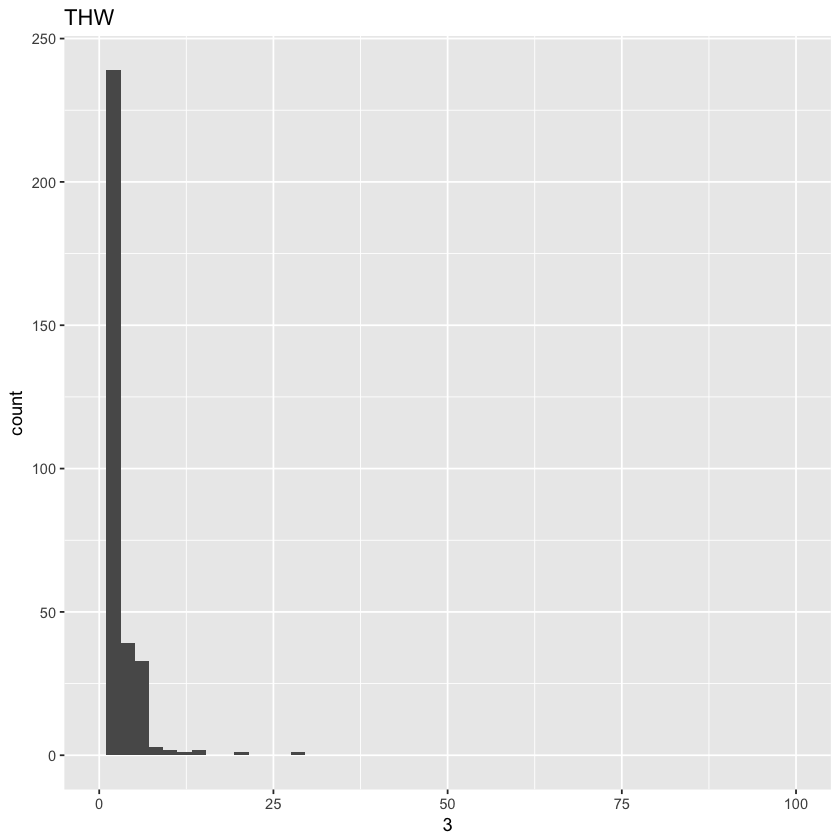

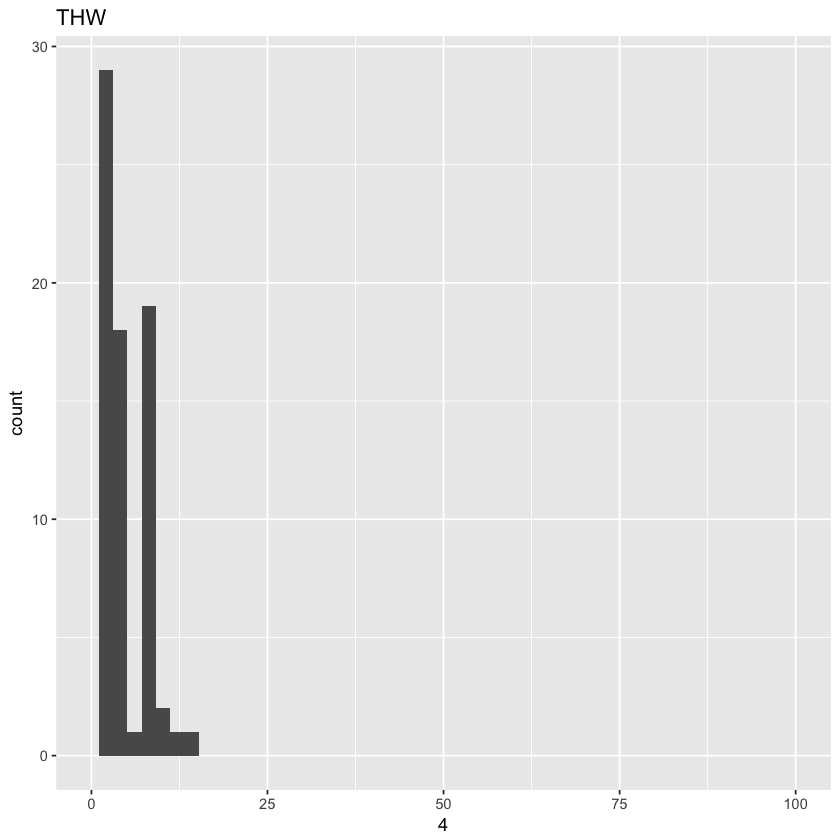

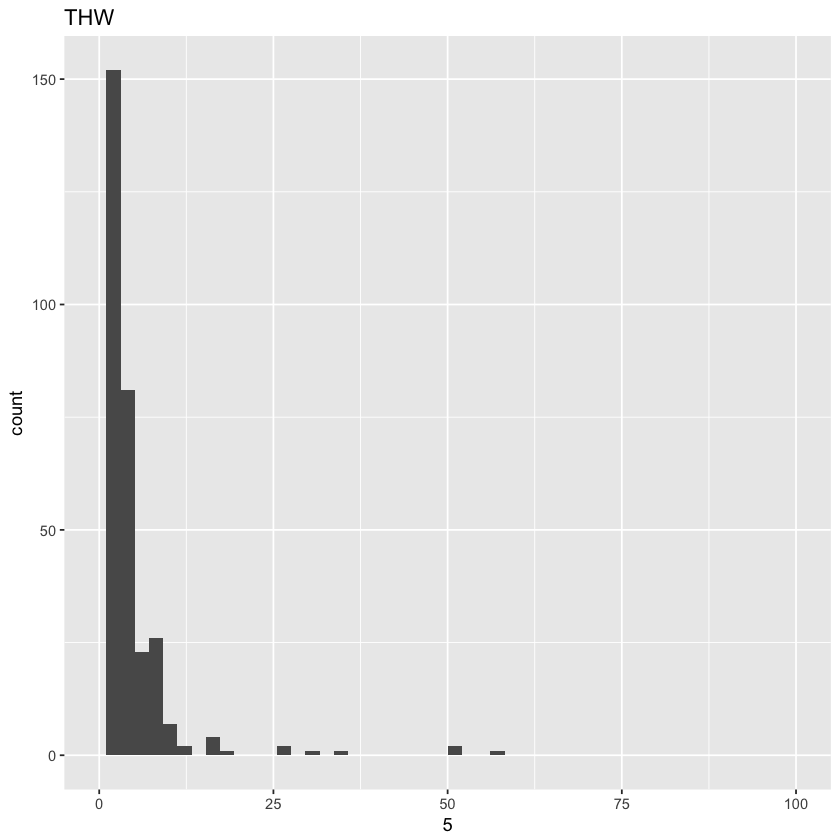

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”

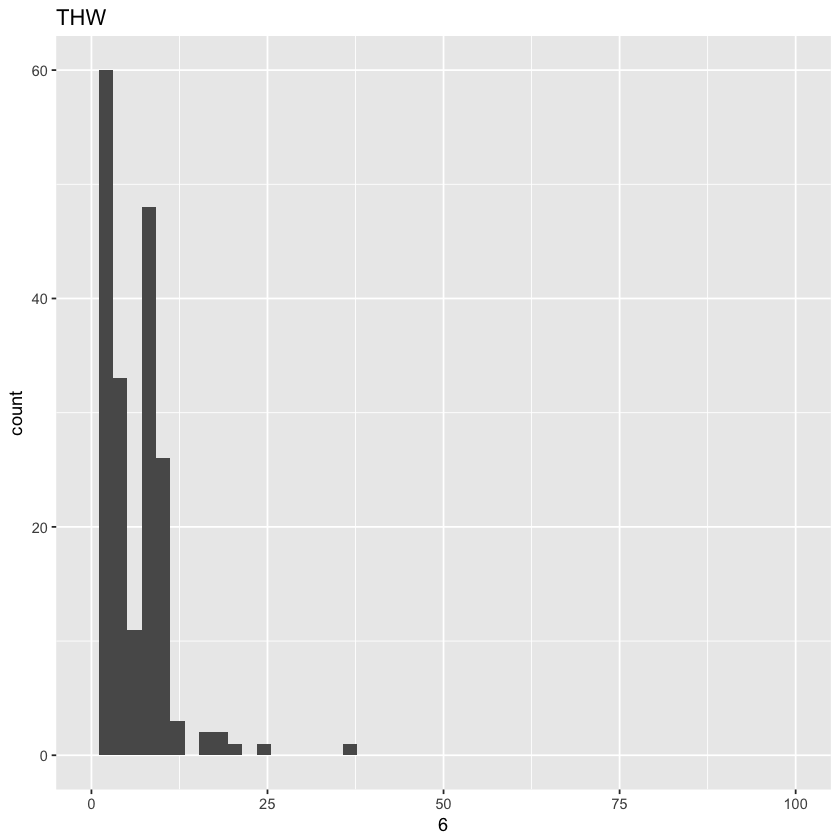

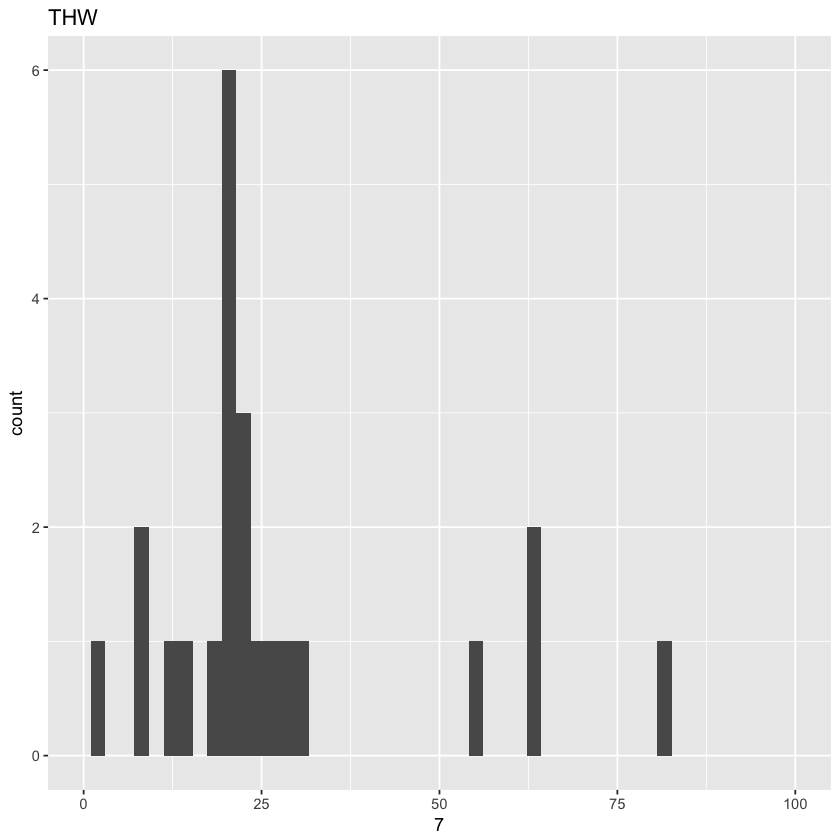

In [41]:
summary(df$TimeHeadway)
p1 <- qplot(df$TimeHeadway, geom="histogram", bins=50, xlim=c(0, 100), main="THW")
# ggsave(p1, file="AllTHW.png")
print(p1)

for (i in c(0, 2, 3, 4, 5, 6, 7)) {
    px <- qplot(df %>% filter(RoadType == i) %>% select(TimeHeadway), geom="histogram", xlim=c(0, 100), bins=50, xlab=i, main="THW")
    # ggsave(plot=px, file=L(f="THW-%d.png", i))
    print(px)  
}

In [34]:
summary(df)

      Time          Longitude        Latitude         Speed            Brake  
 Min.   :  46.3   Min.   :139.3   Min.   :35.40   Min.   :  2.89   Min.   :0  
 1st Qu.:2036.0   1st Qu.:139.4   1st Qu.:35.43   1st Qu.: 22.93   1st Qu.:0  
 Median :3621.2   Median :139.4   Median :35.44   Median : 35.55   Median :0  
 Mean   :3616.8   Mean   :139.4   Mean   :35.46   Mean   : 36.78   Mean   :0  
 3rd Qu.:5234.0   3rd Qu.:139.5   3rd Qu.:35.49   3rd Qu.: 46.45   3rd Qu.:0  
 Max.   :7693.1   Max.   :139.5   Max.   :35.51   Max.   :105.85   Max.   :0  
     Accel        Engine       AheadDistance      Curve150        Curve100    
 Min.   :-1   Min.   : 731.2   Min.   :  3.2   Min.   : 41.0   Min.   : 41.0  
 1st Qu.:-1   1st Qu.:1240.6   1st Qu.: 15.3   1st Qu.:200.0   1st Qu.:203.2  
 Median :-1   Median :1346.9   Median : 25.5   Median :251.0   Median :251.0  
 Mean   :-1   Mean   :1365.2   Mean   : 40.4   Mean   :218.5   Mean   :217.7  
 3rd Qu.:-1   3rd Qu.:1471.9   3rd Qu.: 90.0   3rd Q

In [35]:
write.table(df, "../data/middle/sp3.csv", sep=",", col.names=TRUE, row.names=FALSE)